# Cars 4 You: Expending Car Evaluations with ML

## 1. Import the needed libraries

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import os
from sklearn.metrics import make_scorer 
from sklearn.model_selection import PredefinedSplit

## 2. Data importation and integration

In [710]:
train_data = pd.read_csv('project_data/train.csv')
test_data = pd.read_csv('project_data/test.csv')

In [711]:
data= train_data.copy()

## 3. Data exploration and understanding

### Metadata
- *carID*: An attribute that contains an identifier for each car.
- *Brand*: The car’s main brand (e.g. Ford, Toyota).
- *model*: The car model.
- *year*: The year of Registration of the Car.
- *mileage*: The total reported distance travelled by the car (in
 miles).
- *tax*: The amount of road tax (in £) that, in 2020, was
 applicable to the car in question.
- *fuelType*: Type of Fuel used by the car (Diesel, Petrol, Hybrid,
 Electric).
- *mpg*: Average Miles per Gallon.
- *engineSize*: Size of Engine in liters (Cubic Decimeters).
- *paintQuality%*:  The mechanic’s assessment of the cars’ overall paint
 quality and hull integrity (filled by the mechanic
 during evaluation). 
- *previousOwners*: Number of previous registered owners of the vehicle.
- *hasDamage*:  Boolean marker filled by the seller at the time of
 registration stating whether the car is damaged or
 not.
- *price*: The car’s price when purchased by Cars 4 You (in £).

### 3.1. Data Overview

In [ ]:
#overview the dataset
data.info()

In [ ]:
#first 20 rows
data.head(20)

In [ ]:
#last 20 rows
data.tail(20)

In [ ]:
#Descriptive statistics for numerical data
data.describe().T

In [ ]:
#Descriptive statistics for categorical data
data.describe(include = ['O'])

In [712]:
#separate numerical and categorical features 

metric_features = ['year', 'mileage', 'tax', 'mpg',
                    'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']

non_metric_features= ['Brand','model','transmission','fuelType']

identifier = 'carID'

target = 'price'

In [ ]:
#checking what are the unique values of categorical variables
for col in non_metric_features:
    print(f"\nColumn: {col}")
    print(data[col].unique())

### 3.2. Checking Duplicates

In [ ]:
#Number of duplicates
data.duplicated().sum()

### 3.3. Checking Missing Values

In [ ]:
#Number of missing values
data.isna().sum()

In [ ]:
#Number of missing values in each column as a percentage
data.isna().sum()/len(data) * 100

### 3.4. Checking Outliers

In [713]:
# Checking outliers of numerical variables through the visualization of boxplots

def plot_multiple_boxplots(data, feats, title="Numeric Variables' Box Plots"):

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(4, ceil(len(feats) / 4), figsize=(40, 30))

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), feats):
        sns.boxplot(x=data[feat], ax=ax, color="#5dade2")
        ax.set_title(feat)

    # Layout
    plt.suptitle(title)
    plt.show()

    return

In [ ]:
plot_multiple_boxplots(data, metric_features)

### 3.5. Checking Distributions

In [ ]:
df= pd.DataFrame(data[metric_features])

In [ ]:
# Creating histograms to see the distribrution of numerical variables

num_cols = df.select_dtypes(include=['number']).columns
n = len(num_cols)

# Adjust layout
fig, axes = plt.subplots(nrows=(n // 3) + 1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='#5dade2', edgecolor='black')  
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('frequency')

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Checking Categorical Variables

In [ ]:
# Creating barplots to understand the categorical data

sns.set_style('white')  
sns.set_palette(['#5dade2'])  

# Create 4 subplots stacked vertically
fig, ax = plt.subplots(nrows=4, ncols=1, dpi=300, figsize=(20, 40))
fig.patch.set_facecolor('white') 

# Plot each variable in its own row
sns.countplot(data=test_data, x='Brand', ax=ax[0])
sns.countplot(data=test_data, x='model', ax=ax[1])
sns.countplot(data=test_data, x='transmission', ax=ax[2])
sns.countplot(data=test_data, x='fuelType', ax=ax[3])

# Improve spacing between plots
plt.tight_layout()
plt.show()

### 3.6. Checking Correlation between Variables

In [ ]:
# Check correlation between variables 
# We are going to use spearman correlation since our variables do not follow a normal distribution
cor_spearman = data[metric_features].corr(method ='spearman')
cor_spearman

In [ ]:
# Create correlation matrix to facilitate interpretation

def cor_heatmap(cor):
    plt.figure(figsize=(12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(cor, dtype=bool))

    # Plot heatmap 
    sns.heatmap(
        data=cor,
        mask=mask,
        annot=True,
        cmap='YlGnBu',   
        fmt='.2f',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title("Spearman Correlation Matrix", fontsize=14)
    plt.show()

In [ ]:
cor_heatmap(cor_spearman)

In [ ]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot and use historgrams in the diagonal
sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

# Create eda directory 
if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'pairwise_numeric_scatterplots.png'), dpi=200)
plt.show()

## 4. Data preparation

### 4.1. Set index

In [714]:
# Set index to CarID as each car has its own unique identifier
data.set_index('carID', inplace = True)
test_data.set_index('carID', inplace = True)

### 4.2. Slipt the data into train and validation dataset

#### The Hold Out Method

In [715]:
X = data.drop('price', axis = 1) # In X, the target variable will be removed and the dataset will be used as the training set
y = data['price']  # y corresponds to the target variable

In [716]:
# Splits the dataset

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,  # 30% will be used for validation 
                                                  random_state = 0,      # Ensures the split is always the same every time the code runs
                                                  shuffle = True)        # Shuffles the data before spliting to avoid bias

### 4.3. Changing datatypes

In [717]:
# Rounds the floats and changes them to integers

#year to integer
X_train['year'] = X_train['year'].round().astype('Int32')
X_val['year'] = X_val['year'].round().astype('Int32')
test_data['year'] = test_data['year'].round().astype('Int32')

#previousOwners to integer
X_train['previousOwners'] = X_train['previousOwners'].round().astype('Int32')
X_val['previousOwners'] = X_val['previousOwners'].round().astype('Int32')
test_data['previousOwners'] = test_data['previousOwners'].round().astype('Int32')

#hasDamaged to boolean
X_train['hasDamage'] = X_train['hasDamage'].astype('Int8')
X_val['hasDamage'] = X_val['hasDamage'].astype('Int8')
test_data['hasDamage'] = test_data['hasDamage'].astype('Int8')

In [718]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 42520 to 15659
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           52128 non-null  object 
 1   model           52136 non-null  object 
 2   year            52130 non-null  Int32  
 3   transmission    52086 non-null  object 
 4   mileage         52157 non-null  float64
 5   fuelType        52160 non-null  object 
 6   tax             47671 non-null  float64
 7   mpg             47683 non-null  float64
 8   engineSize      52118 non-null  float64
 9   paintQuality%   52091 non-null  float64
 10  previousOwners  52090 non-null  Int32  
 11  hasDamage       52087 non-null  Int8   
dtypes: Int32(2), Int8(1), float64(5), object(4)
memory usage: 4.7+ MB


### 4.4. Handling Incoherencies

#### 4.4.1. Categorical Variables 

##### 4.4.1.1. Correcting Spelling Mistakes

In [719]:
##correcting spelling mistakes of 'brand' for X_train, X_val and test_data

correct_brand = {
    'VW': ['V', 'vw', 'v', 'W', 'w'],
    'Toyota': ['Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot', 'oyot'],
    'Audi': ['udi', 'AUDI', 'audi', 'Aud', 'aud', 'UDI', 'AUD'],
    'Ford': ['FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    'BMW': ['MW', 'bmw', 'BM', 'mw', 'M', 'bm'],
    'Skoda': ['koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    'Opel': ['Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    'Mercedes': ['mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE'],
    'Hyundai': ['yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'ud', 'hyunda', 'YUNDAI']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_brand.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["Brand"] = X_train["Brand"].replace(replacement_dict)
X_val["Brand"] = X_val["Brand"].replace(replacement_dict)
test_data["Brand"] = test_data["Brand"].replace(replacement_dict)

# Verify the cleaning
print(X_train["Brand"].unique())
print(X_val["Brand"].unique())
print(test_data["Brand"].unique())

['Mercedes' 'Ford' 'Hyundai' 'VW' 'Opel' 'Audi' 'Toyota' 'BMW' nan 'Skoda']
['Mercedes' 'Opel' 'Ford' 'VW' 'Toyota' nan 'BMW' 'Skoda' 'Audi' 'Hyundai']
['Hyundai' 'VW' 'BMW' 'Opel' 'Ford' 'Mercedes' 'Skoda' 'Toyota' 'Audi' nan]


In [720]:
##correcting spelling mistakes of 'model' for X_train, X_val and test_data

correct_model = {
    'Golf': [' GOLF', ' Gol', ' golf', 'golf', ' Golf', ' gol', ' GOL', 'Gol', 'GOLF'],
    'Yaris': [' Yaris', ' YARIS', ' Yari', ' yaris', ' yari', 'Yari', ' YARI', 'yaris', 'YARIS'],
    'Q2': [' q2', ' Q2'],
    '2 Series': [' 2 series', ' 2 serie', '2 Series', ' 2 SERIES', ' 2 Serie', '2 Serie', ' 2 Series'],
    '3 Series': [' 3 Series', ' 3 Serie', ' 3 series', ' 3 SERIES', ' 3 serie', '3 Serie'],
    'A3': [' A3', ' a3'],
    'Octavia': [' Octavi', ' OCTAVIA', ' Octavia', ' octavia', 'Octavi', 'octavia', ' octavi', ' OCTAVI'],
    'Passat': [' PASSAT', ' passat', ' Passa', 'Passat', ' Passat', 'PASSAT', ' PASSA'],
    'Insignia': [' Insigni', ' INSIGNIA', ' insignia', ' Insignia', ' INSIGNI', 'Insigni'],
    'Fabia': [' Fabia', ' fabia', ' FABIA', ' Fabi', 'FABIA'],
    'A Class': [' A Clas', ' A Class', ' a class', ' A CLASS', 'a class', 'A CLASS', ' a clas'],
    'Ka+': [' Ka+', ' KA+', ' ka+', 'ka+'],
    'GLC Class': [' GLC Class', ' GLC CLASS', ' GLC Clas', ' glc class', ' glc clas'], 
    'I30': [' i30', ' I30'],
    'C Class': [' C Clas', ' C CLASS', ' c class', 'C Clas', ' C CLAS', 'c class', ' c clas', ' C Class', 'C CLASS'],
    'Polo': [' POLO', ' Polo', ' polo', ' Pol', ' POL', 'Pol', 'POLO'],
    'E Class': [' E Class', ' E Clas', ' E CLASS', ' e class', 'E CLASS', 'e class'],
    'Q5': [' Q5', ' q5', 'q5'],
    'Up': ['U', ' up', ' UP', ' Up', ' U', 'UP'],
    'Fiesta': [' FIESTA', ' fiesta', ' Fiest', ' Fiesta', 'fiesta', 'Fiest', ' FIESTA', 'FIESTA', ' fiest'],
    'C-HR': [' C-H', ' c-hr', ' C-HR', ' c-h'],
    'Mokka X': [' mokka x', ' MOKKA X', ' Mokka X'],
    'Corsa': [' Corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', 'corsa'],
    'Astra': [' ASTRA', ' Astr', ' Astra', ' astra', 'ASTRA', 'astra'],
    'TT': [' tt', ' TT', ' T'],
    '5 Series': [' 5 Series', ' 5 Serie', ' 5 SERIES', ' 5 series', '5 SERIES', ' 5 SERIE'],
    'Aygo': [' aygo', ' ayg', ' AYGO', ' Ayg', ' Aygo', 'aygo', ' AYG'],
    '4 Series': [' 4 SERIES', ' 4 Serie', ' 4 serie', '4 series', '4 Series', ' 4 Series', ' 4 series'],
    'SLK': [' slk', ' SLK'],
    'Viva': [' viva', ' Viva', ' VIVA', ' Viv', 'viva'],
    'Focus': [' Focus', ' Focu', ' FOCUS', ' focus', ' FOCU', 'focus', 'Focu', ' focu', 'FOCUS'],
    'EcoSport': [' EcoSpor', ' ECOSPORT', ' ecosport', ' EcoSport'],
    'X-CLASS': [' x-clas', ' X-CLAS', ' x-class', ' X-CLASS'],
    'CL Class': [' cl class', ' CL Clas', ' CL CLASS', ' CL Class'],
    'IX20': [' ix20', ' IX20'],
    'Rapid': [' Rapi', ' rapid', ' Rapid'],
    'Auris': [' Auris', ' AURIS', ' auris', ' Auri'],
    'I20': [' i20', ' I20'],
    'X3': [' x3', ' X3'],
    'A8': [' A8', 'a8'],
    'GLS Class': [' GLS Clas', ' GLS CLASS', ' gls class', ' GLS Class'],
    'B-MAX': [' B-MA', ' B-MAX', 'B-MA', ' b-max'],
    'A4': [' A4', ' a4'],
    'Kona': [' KONA', ' Kon', ' Kona', ' KON', ' kona'],
    'I10': [' i10', ' I10'],
    'A1': [' A1', ' a1'],
    'Mokka': [' Mokka ', ' Mokk', ' Mokka', ' mokka ', ' mokka', ' MOKKA', 'Mokka ', 'Mokk'],
    'S-MAX': [' S-MA', ' s-max', ' S-MAX', ' s-ma'],
    'X2': [' x2', ' X2'],
    'Crossland X': [' crossland x', ' CROSSLAND X', ' Crossland X'],
    'Tiguan': [' Tiguan', ' tiguan', ' Tigua', ' TIGUAN', ' TIGUA', 'Tigua', 'TIGUAN', 'tiguan', ' tigua'],
    'A5': [' A5', ' a5', 'a5'],
    'GLE Class': [' GLE Clas', ' GLE Class', ' gle class', ' GLE CLASS'],
    'Zafira': [' Zafira', ' Zafir', ' ZAFIRA', ' zafira', 'Zafir', ' ZAFIR'],
    'Ioniq': [' Ioni', ' Ioniq', ' IONIQ', 'IONIQ', ' ioniq'],
    'A6': [' A6', ' a6'],
    'Yeti Outdoor': [' yeti outdoor', ' Yeti Outdoor', ' YETI OUTDOOR', ' Yeti Outdoo', ' yeti outdoor', 'yeti outdoor', ' yeti outdoo'],
    'X1': [' x1', 'x1', ' X1'],
    'Scala': [' SCALA', ' Scala', ' scala', ' Scal', ' scal'],
    'S Class': [' S Class', ' S Clas', ' s class', ' S CLASS'],
    '1 Series': [' 1 Series', ' 1 SERIES', ' 1 Serie', ' 1 series', '1 SERIES', ' 1 SERIE', '1 series', ' 1 serie'],
    'Kamiq': [' KAMIQ', ' KAMI', ' kamiq', ' Kamiq'],
    'Kuga': [' Kug', ' KUGA', ' kuga', 'Kuga', ' Kuga', 'kuga'],
    'Tourneo Connect': [' tourneo connect', ' Tourneo Connect'],
    'Q7': [' q7', ' Q7'],
    'GLA Class': [' GLA Class', ' GLA CLASS', ' GLA Clas', ' gla class'],
    'Arteon': [' arteon', ' Arteon', ' Arteon'],
    'SL CLASS': [' SL CLAS', ' SL CLASS', ' sl class', ' SL'],
    'Tucson': [' Tucson', ' TUCSON', ' Tucso', ' tucson', ' TUCSO', 'Tucso'],
    'Santa Fe': [' Santa F', ' santa fe', ' SANTA FE', ' Santa Fe'],
    'Grandland X': [' Grandland X', ' grandland x', ' GRANDLAND X'],
    'RAV4': [' rav4', 'RAV4', 'RAV', ' RAV', 'rav4', ' rav', ' RAV4'],
    'Touran': [' Touran', 'Toura', ' TOURAN', ' touran', ' Toura', ' TOURA'],
    'Citigo': [' Citig', ' citigo', ' Citigo', ' CITIGO', 'CITIGO'],
    'Roomster': [' Roomste', ' Roomster'],
    'Prius': [' PRIUS', ' Prius', 'Prius', ' prius'],
    'Corolla': [' corolla', ' COROLLA', ' Coroll', ' Corolla', 'corolla'],
    'B Class': [' b class', ' B Clas', ' B Class', ' B CLASS', 'b class'],
    'Sharan': [' sharan', ' Shara', ' Sharan', ' SHARAN'],
    'Kodiaq': [' Kodia', ' kodiaq', 'kodiaq', ' KODIAQ', ' Kodiaq'],
    'V Class': [' V Clas', ' V CLASS', ' V Class', ' v class'],
    'Caddy Maxi Life': [' Caddy Maxi Lif', ' Caddy Maxi Life'],
    'Superb': [' Superb', ' Super', ' SUPERB', ' superb', ' super'],
    'T-Roc': [' T-Roc', ' T-RO', ' t-roc', ' T-Ro', ' T-ROC'],
    'Combo Life': [' COMBO LIFE', ' combo life', ' Combo Lif', 'COMBO LIFE', ' Combo Life'],
    'Beetle': [' Beetl', ' Beetle', ' beetle'],
    'Galaxy': [' GALAXY', ' Galax', ' galaxy', ' Galaxy'],
    'M3': [' M3', ' m3'],
    'Gtc': [' gtc', ' GTC', ' gtc', 'gtc', 'GTC'],
    'X4': [' X4', ' x4'],
    'KA': [' Ka', ' ka', ' K', ' KA'],
    'IX35': [' ix35', ' IX35'],
    'Grand Tourneo Connect': [' Grand Tourneo Connec', ' Grand Tourneo Connect'],
    'M4': [' m4', ' M4'],
    'Tourneo Custom': [' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    'Z4': [' Z4', ' z4'],
    'X5': [' X5', ' x5'],
    'Meriva': [' Meriva', ' MERIVA', ' Meriv', ' meriva'],
    'RS6': [' RS6'],
    'Verso': [' VERSO', ' verso', ' Verso', ' Vers'],
    'Touareg': [' Touareg', ' TOUAREG', ' touareg', ' Touare'],
    'Mondeo': [' MONDEO', ' Mondeo', ' mondeo', ' MONDE', ' Monde'],
    'Shuttle': [' shuttle', ' Shuttle', ' SHUTTLE'],
    'CLS Class': [' CLS Class', ' cls class', ' CLS Clas', ' CLS CLASS'], 
    'C-MAX': [' C-MAX', ' c-max', ' C-MA'],
    'Puma': [' puma', ' PUMA', ' Puma', 'Pum', ' Pum'],
    'CLA Class': [' CLA Class', ' CLA CLASS', ' cla class', ' CLA Clas'],
    'I40': [' I40', ' i40'],
    'Q3': [' q3', ' Q3'],
    'Tiguan Allspace': [' TIGUAN ALLSPACE', ' tiguan allspace', ' Tiguan Allspac', ' Tiguan Allspace'],
    '6 Series': [' 6 SERIES', ' 6 series', ' 6 Series', ' 6 Serie'],
    'Caravelle': [' caravelle', ' Caravell', ' Caravelle'],
    'Karoq': [' Karoq', ' karoq', ' KAROQ', ' Karo'],
    'I3': [' i3', 'i3', ' I3'],
    'Grand C-MAX': [' GRAND C-MAX', ' grand c-max', ' Grand C-MA', ' Grand C-MAX'],
    'T-Cross': [' T-Cros', ' T-CROSS', ' T-Cross', ' t-cros', ' t-cross'],
    'A7': [' a7', ' A7'],
    'Golf SV': [' Golf SV', ' golf sv', ' GOLF SV'],
    'A': [' a', ' A'],
    'GT86': [' gt86', ' GT86'],
    'Yeti': [' yeti', ' Yet', ' Yeti', ' YETI'],
    'X': [' x', ' X'],
    'Land Cruiser': [' Land Cruise', ' Land Cruiser', ' land cruiser'],
    'EDGE': [' Edge', ' edge', ' Edg', ' EDGE'],
    'X6': [' X6'],
    'Fusion': [' Fusion', ' fusion'],
    'GL Class': [' GL CLASS', ' gl class', ' GL Class', ' GL Clas'],
    'Scirocco': [' scirocco', ' SCIROCCO', ' Scirocc', ' Scirocco'],
    'Z3': [' Z3'],
    'Hilux': [' hilux', ' Hilux', ' Hilu', ' HILU'],
    'Amarok': [' amarok', ' Amarok', ' Amaro'],
    'CC': [' cc', ' CC'],
    '7 Series': [' 7 Serie', ' 7 SERIES', ' 7 series', ' 7 Series'],
    'Avensis': [' AVENSIS', ' avensis', ' Avensis'],
    'M Class': [' m class', ' M CLASS', ' M Class', ' M Clas', ' M CLAS'],
    'Grandland': [' grandland ', ' Grandland '],
    'Zafira Tourer': [' Zafira Toure', ' ZAFIRA TOURER', ' Zafira Tourer', ' zafira tourer'],
    'R8': [' R8', ' r8'],
    'Mustang': [' mustang', ' Mustang'],
    'Q8': [' Q8'],
    'CLK': [' CLK'],
    'RS3': [' RS3'],
    'Jetta': [' JETTA', ' Jetta', ' jetta', 'Jetta' ],
    'Supra': [' Supra'],
    'X7': [' X7'],
    'SQ7': [' SQ7', ' sq7'],
    'S3': [' s3', ' S3'],
    'Arteon': [' Arteo', 'Arteo', ' ARTEON', ' arteon', ' Arteon'],
    'GLB Class': [' glb class', ' GLB Class'],
    'Adam': [' Ada', ' adam', ' ADAM', ' Adam'],
    'M5': [' M5',' m5'],
    'Golf S': [' golf s', ' Golf S'],
    'Vectra': ['Vectra', ' Vectra', ' VECTRA', 'VECTRA'],
    '8 Series': [' 8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    'Urban Cruiser': [' Urban Cruise', ' Urban Cruiser'],
    'Fox': ['fox', ' fox', ' Fox'], 
    'Q': [' Q'], 
    'M2': [' M2'], 
    'RS4':[' RS4'], 
    'Veloster': [' Veloster', ' Veloste'],  
    'IQ': [' IQ'], 
    'Agila': [' AGILA', ' Agila'], 
    'I2': [' I2'], 
    'Antara': [' Antara', ' antara'], 
    'G Class': [' G Class', ' G CLAS'], 
    'Caddy Life': [' Caddy Life', ' Caddy'],
    'R Class': [' R Class'], 
    'I800': [' I800'],
    'Amica': [' Amica'], 
    'Crossland': [' Crossland '],
    'Proace Verso': [' proace verso', ' PROACE VERSO', 'PROACE VERSO'],
    'Camry': [' Camry', 'Camry', ' Camr'], 
    'Tigra': [' Tigra'], 
    'Eos': [' Eos'], 
    'M': [' M'],
    'California': [' Californi', ' California'], 
    'Ampera': [' Ampera'], 
    'I1': [' I1'], 
    'S5': [' S5'], 
    'CLC Class': [' CLC Class'], 
    'Shara': [' SHARA'], 
    'I8': [' i8', 'i8'], 
    'RS7': [' RS7'], 
    'Transit Tourneo': [' Transit Tourneo'], 
    'I4': [' I4'], 
    'S4':[' S4'], 
    'Terracan': [' Terracan'], 
    'Cascada': [' Cascada'], 
    'S8': [' S8'], 
    'A2':[' A2'], 
    'Vivaro':[' Vivaro'],
    'RS5':[' RS5'],
    'SQ5':[' SQ5'], 
    'Getz':[' Getz'], 
    'M6':[' M6'], 
    'Caddy Maxi': [' Caddy Maxi'], 
    'Z':[' Z'], 
    'Verso-S': [' Verso-S'], 
    'Kadjar': [' Kadjar'], 
    'I80': [' I80'], 
    'Streetka': [' Streetka'],
    'RS': [' RS'], 
    'I': [' i'], 
    'Ranger': [' Ranger'], 
    'IX2': [' IX2'], 
    'Escort': [' Escort'],
    'Accent': [' Accent']
}


# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_model.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["model"] = X_train["model"].replace(replacement_dict)
X_val["model"] = X_val["model"].replace(replacement_dict)
test_data["model"] = test_data["model"].replace(replacement_dict)

# Verify the cleaning
print(X_train["model"].unique())
print(X_val["model"].unique())
print(test_data["model"].unique())

['E Class' 'Focus' 'C Class' 'IX20' 'Golf' 'I10' 'T-Cross' 'Corsa' 'A4'
 'Polo' 'Tucson' 'Kuga' 'Corolla' 'Yaris' 'Q3' 'A Class' 'A1' 'A5' 'Q5'
 'GLE Class' '3 Series' 'Fiesta' 'T-Roc' 'Insignia' 'GLC Class' 'X1'
 'Astra' 'Q2' 'Aygo' 'C-MAX' 'Q' '2 Series' 'A3' 'Touran' 'TT' 'Santa Fe'
 'C-HR' 'Superb' 'EDGE' 'S Class' 'CL Class' 'Ka+' 'Octavia' 'Arteon' 'X4'
 'Z4' nan 'EcoSport' 'Yeti Outdoor' 'Meriva' 'I20' 'Hilux' 'X5' 'M4'
 'CLA Class' '1 Series' 'Mokka X' 'Prius' 'X2' '4 Series' 'S4' 'Fabia'
 'Auris' 'Galaxy' 'Citigo' 'A6' 'RAV4' 'Passat' 'Grand C-MAX' 'Adam'
 'GLA Class' 'G Class' 'Zafira' 'Touareg' 'Sharan' 'Mokka' 'Tiguan'
 'Ioniq' 'Q7' 'Viva' 'X3' 'Tiguan Allspace' 'B Class' 'Up' 'Crossland X'
 'CLS Class' 'SLK' 'Kodiaq' 'Mondeo' 'B-MAX' 'Caddy Life' 'SL CLASS' 'A7'
 'A' 'I30' 'Yeti' 'Grandland X' 'Tourneo Custom' 'Antara' 'Avensis' 'X6'
 '5 Series' 'GL Class' 'IX35' 'Kamiq' 'KA' 'Caravelle' 'Karoq' 'Scala'
 'V Class' 'Golf SV' 'Verso' 'Kona' '7 Series' '6 Series' 'SQ7' 'Golf 

In [721]:
##correcting spelling mistakes of 'transmission' for X_train, X_val and test_data

correct_transmission = {
    'Semi-Auto': ['Semi-Aut', 'semi-auto', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT', 'EMI-AUTO', 'emi-Aut', 'emi-auto', 'semi-aut'],
    'Manual': ['anual', 'manual', 'Manua', 'MANUAL', ' Manual ', 'ANUAL', 'manua', 'anua', 'MANUA', ' manual ', ' MANUAL ', ' Manual', 'Manual ', 'manual '],
    'Automatic': ['AUTOMATIC', 'automatic', 'Automati', 'utomatic', 'UTOMATIC', 'automati', 'AUTOMATI', 'utomati'],
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_transmission.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["transmission"] = X_train["transmission"].replace(replacement_dict)
X_val["transmission"] = X_val["transmission"].replace(replacement_dict)
test_data["transmission"] = test_data["transmission"].replace(replacement_dict)

#replacing the 'unknown' and 'other' variable with a missing value
X_train["transmission"] = X_train["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)
X_val["transmission"] = X_val["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)
test_data["transmission"] = test_data["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)

# Verify the cleaning
print(X_train["transmission"].unique())
print(X_val["transmission"].unique())
print(test_data["transmission"].unique())

['Semi-Auto' 'Automatic' 'Manual' nan]
['Semi-Auto' 'Manual' nan 'Automatic']
['Automatic' 'Semi-Auto' 'Manual' nan]


In [722]:
##correcting spelling mistakes of 'fuelType' for X_train, X_val and test_data

correct_fuelType = {
    'Petrol': ['etrol', 'petrol', 'PETROL', 'Petro', 'petro', 'ETROL', 'PETRO', 'etro', 'ETRO'],
    'Diesel': ['diesel','iesel','Diese','DIESEL','DIESE','IESEL','iese','diese','IESE'],
    'Hybrid': ['HYBRID','ybri','Hybri','ybrid','hybrid','YBRID','HYBRI', 'hybri'],
    'Other': ['ther','Othe','OTHER','other']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_fuelType.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["fuelType"] = X_train["fuelType"].replace(replacement_dict)
X_val["fuelType"] = X_val["fuelType"].replace(replacement_dict)
test_data["fuelType"] = test_data["fuelType"].replace(replacement_dict)

#replacing the 'other' variable with a missing value 
X_train["fuelType"] = X_train["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)
X_val["fuelType"] = X_val["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)
test_data["fuelType"] = test_data["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)

# Verify the cleaning
print(X_train["fuelType"].unique())
print(X_val["fuelType"].unique())
print(test_data["fuelType"].unique())

['Diesel' 'Petrol' 'Hybrid' nan 'Electric']
['Diesel' 'Petrol' nan 'Hybrid']
['Petrol' 'Diesel' 'Hybrid' nan 'Electric']


##### 4.4.1.2. Check if the Models correspond to the Brand

**Audi**

In [723]:
#Check the models of Audi for X_train
audi = X_train[X_train['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

['A',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

In [724]:
#Check the models of Audi for X_val
audi = X_val[X_val['Brand'].str.lower() == 'audi']
unique_audi_models_v = sorted(audi['model'].dropna().unique())
unique_audi_models_v

['A',
 'A1',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S5',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

In [725]:
#Check the models of Audi for test_data
audi = test_data[test_data['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

['A',
 'A1',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'RS7',
 'S3',
 'S4',
 'S5',
 'SQ5',
 'SQ7',
 'TT']

- All models seem to correspond to Audi cars, except for models 'A' and 'Q'. There are no models in Audi that are named 'A' and 'Q' solely, normally there are followed by a number, for example, 'A1' or 'Q3' as seen in the dataset. 
- Since it might be a problem of data collection, in a way that is missing a number after the letter, we have decided to replace these values by missing values. 

In [726]:
#replacing model 'A' by missing values
X_train.loc[X_train["model"] == 'A', "model"] = np.nan
X_val.loc[X_val["model"] == 'A', "model"] = np.nan
test_data.loc[test_data["model"] == 'A', "model"] = np.nan

In [727]:
#replacing model 'Q' by missing values
X_train.loc[X_train["model"] == 'Q', "model"] = np.nan
X_val.loc[X_val["model"] == 'Q', "model"] = np.nan
test_data.loc[test_data["model"] == 'Q', "model"] = np.nan

**BMW**

In [728]:
#Check the models of 'BMW' for X_train
BMW = X_train[X_train['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z',
 'Z3',
 'Z4']

In [729]:
#Check the models of 'BMW' for X_val
BMW = X_val[X_val['Brand'].str.lower() == 'bmw']
unique_bmw_models_v = sorted(BMW['model'].dropna().unique())
unique_bmw_models_v

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z3',
 'Z4']

In [730]:
#Check the models of 'BMW' for test_data
BMW = test_data[test_data['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

['1 Series',
 '2 Series',
 '2 series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z3',
 'Z4']

- Similarly to 'Audi', in 'BMW' there are also models that should be followed by a number, which are 'X', 'Z', 'I' and 'M'.
- Therefore, we are going to replace it by missing values, for the same reason. 

In [731]:
#replacing model 'X' by missing values
X_train.loc[X_train["model"] == 'X', "model"] = np.nan
X_val.loc[X_val["model"] == 'X', "model"] = np.nan
test_data.loc[test_data["model"] == 'X', "model"] = np.nan

In [732]:
#replacing model 'Z' by missing values
X_train.loc[X_train["model"] == 'Z', "model"] = np.nan

In [733]:
#replacing model 'I' by missing values
X_train.loc[X_train["model"] == 'I', "model"] = np.nan

In [734]:
#replacing model 'M' by missing values
X_train.loc[X_train["model"] == 'M', "model"] = np.nan
X_val.loc[X_val["model"] == 'M', "model"] = np.nan
test_data.loc[test_data["model"] == 'M', "model"] = np.nan

**Ford**

In [735]:
#Check the models of 'Ford' for X_train
Ford = X_train[X_train['Brand'].str.lower() == 'ford']
unique_ford_models = sorted(Ford['model'].dropna().unique())
unique_ford_models

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Escort',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'Ranger',
 'S-MAX',
 'Streetka',
 'Tourneo Connect',
 'Tourneo Custom']

In [736]:
#Check the models of 'Ford' for X_val
Ford = X_val[X_val['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'S-MAX',
 'Tourneo Connect',
 'Tourneo Custom']

In [737]:
#Check the models of 'Ford' for test_data
Ford = test_data[test_data['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'S-MAX',
 'Tourneo Connect',
 'Tourneo Custom',
 'Transit Tourneo']

- All the models from the lists correspond to Ford models. 

**Hyundai**

In [738]:
#Check the models of 'Hyundai' for X_train
Hyundai = X_train[X_train['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

['Accent',
 'Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q7',
 'Santa Fe',
 'Tucson',
 'Veloster']

In [739]:
#Check the models of 'Hyundai' for X_train
Hyundai = X_val[X_val['Brand'].str.lower() == 'hyundai']
unique_hyundai_models_v = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models_v

['Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q3',
 'Q5',
 'Santa Fe',
 'Terracan',
 'Tucson']

In [740]:
#Check the models of 'Hyundai' for test_data
Hyundai = test_data[test_data['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

['A5',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I4',
 'I40',
 'I800',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q2',
 'Q3',
 'Santa Fe',
 'Terracan',
 'Tucson',
 'Veloster']

- Models 'Q2', 'Q3', 'Q5', 'Q7', 'A5' are from 'Audi' not from 'Hyundai'. There are no such models in Hyundai. 
- Here, since the number of observations where the brand is a hyundai and the model is either 'Q3', 'Q5', or 'Q7 is low, it was assumes it was a mistake of the brand name, so the brand was changed from 'Hyundai' to 'Audi'. 

In [741]:
# Replace Hyundai Q7 by Audi Q7 of X_train
mask_train = (X_train["Brand"] == "Hyundai") & (X_train["model"] == "Q7")
X_train.loc[mask_train, "Brand"] = "Audi"
X_train.loc[mask_train, "model"] = "Q7"

# Replace Hyundai Q3 by Audi Q3 of X_val
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q3")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q3"

# Replace Hyundai Q5 by Audi Q5 of X_val
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q5")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q5"

# Replace Hyundai A5 by Audi A5 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "A5")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "A5"

# Replace Hyundai Q2 by Audi Q2 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q2")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q2"

# Replace Hyundai Q3 by Audi Q3 of test_data
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q3")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q3"


**Mercedes**

In [742]:
#Check the models of 'Mercedes' for X_train
Mercedes = X_train[X_train['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

['230',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLC Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

In [743]:
#Check the models of 'Mercedes' for X_val
Mercedes = X_val[X_val['Brand'].str.lower() == 'mercedes']
unique_mercedes_models_v = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models_v

['200',
 '220',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

In [744]:
#Check the models of 'Mercedes' for test_data
Mercedes = test_data[test_data['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

['180',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLC Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'R Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

- In Mercedes, 200, 220, 230 and 180 are not complete model names, they refer only to the engine/variant, not the class or body style. 
- Therefore, we have decided to replace them by missing values.

In [745]:
#replacing model '230' by missing value of X_train
X_train.loc[X_train["model"] == '230', "model"] = np.nan

#replacing model '200' by missing value of X_val
X_val.loc[X_val["model"] == '200', "model"] = np.nan

#replacing model '220' by missing value of X_val
X_val.loc[X_val["model"] == '220', "model"] = np.nan

#replacing model '180' by missing value of test_data
test_data.loc[test_data["model"] == '180', "model"] = np.nan

**Opel**

In [746]:
#Check the models of 'Opel' for X_train
Opel = X_train[X_train['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

['Adam',
 'Agila',
 'Ampera',
 'Antara',
 'Astra',
 'Cascada',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Tigra',
 'Vectra',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

In [747]:
#Check the models of 'Opel' for X_val
Opel = X_val[X_val['Brand'].str.lower() == 'opel']
unique_opel_models_v = sorted(Opel['model'].dropna().unique())
unique_opel_models_v

['Adam',
 'Agila',
 'Antara',
 'Astra',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

In [748]:
#Check the models of 'Opel' for test_data
Opel = test_data[test_data['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

['Adam',
 'Agila',
 'Ampera',
 'Antara',
 'Astra',
 'Cascada',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Tigra',
 'Vectra',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

- 'Kadjar' is a 'Renault' model not a 'Opel' model.
- Since the brand 'Renault' is not in our dataset, we have decided to replace this model by missing values. 

In [749]:
#replacing model 'Kadjar' by missing value
X_train.loc[X_train["model"] == 'Kadjar', "model"] = np.nan
X_val.loc[X_val["model"] == 'Kadjar', "model"] = np.nan

**Skoda**

In [750]:
#Check the models of 'Skoda' for X_train
Skoda = X_train[X_train['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

In [751]:
#Check the models of 'Skoda' for X_val
Skoda = X_val[X_val['Brand'].str.lower() == 'skoda']
unique_skoda_models_v = sorted(Skoda['model'].dropna().unique())
unique_skoda_models_v

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

In [752]:
#Check the models of 'Skoda' for test_data
Skoda = test_data[test_data['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

- All the models showed seem to correspond to the brand 'Skoda'.

**VW**

In [753]:
#Check the models of 'VW' fro X_train
VW = X_train[X_train['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up']

In [754]:
#Check the models of 'VW' for X_val
VW = X_val[X_val['Brand'].str.lower() == 'vw']
unique_vw_models_v = sorted(VW['model'].dropna().unique())
unique_vw_models_v

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Fox',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up',
 'polo']

In [755]:
#Check the models of 'VW' for test_data
VW = test_data[test_data['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Fox',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Shara',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up']

In [756]:
#replacing 'Shara' by the correct name for test_data
test_data.loc[test_data["model"] == 'Shara', "model"] = 'Sharan'

- In x_train and X_val, all the models showed seem to correspond to the brand 'VW'.
- In test_data, *Shara* is not the right VW model, the correct would be 'Sharan'. 

#### 4.4.2. Numerical Variables 

##### 4.4.2.1. Correcting variables' incoherent values

**Previous Owners**

In [757]:
#checking negative values for X_train
X_train[X_train['previousOwners'] < 0]['previousOwners']

carID
75498    -2
29008    -2
61598    -2
41596    -2
73060    -2
         ..
66085    -2
63759    -2
75549    -2
59833    -2
65364    -2
Name: previousOwners, Length: 265, dtype: Int32

In [758]:
#checking negative values for X_val 
X_val[X_val['previousOwners'] < 0]['previousOwners']

carID
48893    -2
27263    -2
64618    -2
19970    -2
55427    -2
         ..
75662    -2
31261    -2
50689    -2
52063    -2
49608    -2
Name: previousOwners, Length: 106, dtype: Int32

In [759]:
#checking negative values for test_data
test_data[test_data['previousOwners'] < 0]['previousOwners']

carID
104574    -2
102304    -2
78379     -2
76435     -2
76702     -2
          ..
95465     -2
86894     -2
98334     -2
107094    -2
103453    -2
Name: previousOwners, Length: 168, dtype: Int32

- The training dataset has 265 cars with negative owners and the validation set has 106, all equal to -2, which is not possible. - Since the mean value of the previousOwners is 1.994580 and the median is 2, we made the assumption that these negative values are spelling mistakes made during the data collection, that added the '-'. Therefore, we decided the change all of the negative values to positive.

In [760]:
#replacing the negative values by their module.
X_train['previousOwners'] = X_train['previousOwners'].replace(-2, 2)
X_val['previousOwners'] = X_val['previousOwners'].replace(-2, 2)
test_data['previousOwners'] = test_data['previousOwners'].replace(-2, 2)

**Milage**

In [761]:
#checking negative observations for X_train 
X_train[X_train['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
30017,Ford,EDGE,2016,Automatic,-42650.453719,Diesel,200.0,47.9,2.0,83.000000,0,0
52522,Toyota,Auris,2016,NaN,-39765.602338,Hybrid,0.0,70.6,1.8,86.000000,2,0
70201,VW,T-Roc,2018,Manual,-48190.655673,Petrol,150.0,53.3,1.5,NaN,2,0
43065,Mercedes,SLK,2007,NaN,-50755.210230,Petrol,325.0,32.1,1.8,92.000000,4,0
30227,Ford,Fiesta,2016,Automatic,-42650.453719,Petrol,30.0,57.7,1.0,45.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
70143,VW,Caravelle,2016,Manual,-48190.655673,Diesel,235.0,42.8,2.0,1.769474,4,0
75549,VW,Golf SV,2016,Automatic,-48190.655673,Petrol,30.0,54.3,1.4,59.000000,2,0
24436,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,125.0,54.3,1.2,97.000000,<NA>,0


In [762]:
#checking negative observations for X_val
X_val[X_val['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
37025,Mercedes,C Class,2016,Semi-Auto,-50755.210230,Diesel,30.0,64.2,1.6,NaN,0,0
47157,Skoda,Octavia,2019,Manual,-46497.584838,Petrol,145.0,55.4,1.5,89.0,1,0
6786,Audi,Q7,2019,Semi-Auto,-52618.457894,Diesel,150.0,33.6,3.0,43.0,3,0
25030,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,145.0,65.7,1.0,34.0,4,0
17015,Ford,Fiesta,2018,Manual,-42650.453719,Petrol,145.0,65.7,1.0,33.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60678,Opel,Mokka,2016,Manual,-42707.564215,NaN,160.0,44.8,1.4,60.0,1,0
72628,VW,Arteon,2020,Semi-Auto,-48190.655673,Petrol,150.0,32.8,2.0,83.0,1,0
45883,Mercedes,E Class,2016,Semi-Auto,-50755.210230,Diesel,160.0,50.4,3.0,48.0,4,0


In [763]:
#checking negative observations for test_data
test_data[test_data['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
106581,VW,Tiguan,2017,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2,0
92673,Mercedes,C Class,2017,NaN,-50755.210230,Diesel,NaN,NaN,2.1,93.0,2,0
93065,Mercedes,C Class,2019,Semi-Auto,-50755.210230,Petrol,NaN,NaN,3.0,97.0,4,0
89444,Hyundai,Tucson,2020,Semi-Auto,-36635.042697,Hybrid,150.0,50.4,1.6,41.0,0,0
85269,Ford,Mondeo,2017,Automatic,-42650.453719,Diesel,20.0,67.3,2.0,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100676,Opel,Cascada,2015,Manual,-42707.564215,Diesel,125.0,57.6,2.0,77.0,2,0
92455,Mercedes,C Class,2019,Semi-Auto,-50755.210230,Petrol,NaN,NaN,2.0,59.0,2,0
106053,VW,Polo,2017,Manual,-48190.655673,Petrol,20.0,58.9,1.0,72.0,4,0


- Here we have 247 negative values in the training set and 122 in the validation. 
- Since, it appers that these negative numbers do not have any kind of relationship, we decided to convert them into missing values to fill them in later.

In [764]:
#replacing negative values by missing values 
X_train.loc[X_train["mileage"] < 0, "mileage"] = np.nan
X_val.loc[X_val["mileage"] < 0, "mileage"] = np.nan
test_data.loc[test_data["mileage"] < 0, "mileage"] = np.nan

**Mpg**

In [765]:
#checking negative observations for X_train 
X_train[X_train['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14662,BMW,4 Series,2019,Automatic,123.0,Diesel,145.0,-43.421768,2.0,58.0,0,0
13698,BMW,3 Series,2016,Manual,59222.0,Diesel,125.0,-43.421768,2.0,74.0,1,0
14420,BMW,2 Series,2015,Automatic,38902.0,Petrol,260.0,-43.421768,3.0,33.0,4,0
11883,BMW,2 Series,2019,Semi-Auto,9531.0,Diesel,150.0,-43.421768,2.0,64.0,4,0
13134,BMW,1 Series,2016,Manual,NaN,Petrol,30.0,-43.421768,1.5,70.0,2,0
10078,BMW,6 Series,2019,Semi-Auto,27713.0,Diesel,145.0,-43.421768,3.0,47.0,1,0
13574,BMW,3 Series,2017,Semi-Auto,25000.0,Diesel,30.0,-43.421768,2.0,43.0,0,0
12352,BMW,M3,2018,Semi-Auto,12879.0,Petrol,150.0,-43.421768,3.0,59.0,1,0
8542,NaN,3 Series,2013,Semi-Auto,40900.0,Diesel,145.0,-43.421768,3.0,88.0,<NA>,0


In [766]:
#checking negative observations for X_val
X_val[X_val['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14934,BMW,3 Series,2019,Automatic,3185.0,Petrol,145.000000,-43.421768,2.0,97.0,3,0
13723,BMW,5 Series,<NA>,Automatic,34599.0,Diesel,30.000000,-43.421768,2.0,43.0,3,0
13140,BMW,1 Series,2019,Automatic,6744.0,Petrol,-43.242082,-43.421768,1.5,57.0,3,0
12400,BMW,X5,2016,Automatic,46126.0,Diesel,200.000000,-43.421768,3.0,77.0,2,0
13874,BMW,2 Series,2014,Automatic,45868.0,Petrol,145.000000,-43.421768,2.0,95.0,0,0
11921,BMW,2 Series,2017,NaN,14612.0,Diesel,145.000000,-43.421768,2.0,92.0,2,0
10214,BMW,3 Series,2014,Automatic,45140.0,Diesel,125.000000,-43.421768,3.0,77.0,2,0
13855,BMW,3 Series,<NA>,Automatic,27725.0,Diesel,145.000000,-43.421768,2.0,96.0,1,0
11143,BMW,Z4,2013,Semi-Auto,26356.0,Petrol,200.000000,-43.421768,2.0,44.0,4,0


In [767]:
#checking negative observations for tes_data
test_data[test_data['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
79461,BMW,5 Series,2016,Automatic,83189.0,Diesel,20.000000,-43.421768,2.000000,68.0,2,0
81976,BMW,3 Series,2019,Semi-Auto,6000.0,Diesel,145.000000,-43.421768,3.822758,86.0,1,0
80175,BMW,X1,2016,Manual,NaN,Diesel,20.000000,-43.421768,2.000000,32.0,0,0
80445,BMW,1 Series,2015,Manual,46000.0,Petrol,125.000000,-43.421768,1.500000,54.0,0,0
79366,BMW,X3,2015,Semi-Auto,44126.0,Diesel,200.000000,-43.421768,3.000000,79.0,3,0
82248,BMW,5 Series,2019,Semi-Auto,5130.0,Diesel,145.000000,-43.421768,2.000000,41.0,4,0
80677,BMW,1 Series,2015,Semi-Auto,46242.0,Diesel,30.000000,-43.421768,2.000000,74.0,0,0
79287,BMW,3 Series,2019,Semi-Auto,23000.0,Petrol,150.000000,-43.421768,2.000000,41.0,2,0
82168,BMW,3 Series,2016,Manual,27796.0,Petrol,205.000000,-43.421768,2.000000,97.0,2,0


- We can observe that negative values are all the same. In the context of the variable 'mpg', it is not normal to have dozens of cars with the exact same number of milles per gallon, since the car's consumption are dependent on a lot of factors such as the driver, the age of the car and the way the car is used. We have also noticed that all of the cars with negative values are BMWs, so it was probably an error related to the brand. 
- Therefore we decided to replace them with missing values to fill them afterwards.

In [768]:
#replacing negative values by missing values 
X_train.loc[X_train["mpg"] < 0, "mpg"] = np.nan
X_val.loc[X_val["mpg"] < 0, "mpg"] = np.nan
test_data.loc[test_data["mpg"] < 0, "mpg"] = np.nan

In [769]:
#checking electric cars for X_train
X_train[X_train['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
21931,Ford,Mondeo,<NA>,Automatic,24531.0,Electric,0.0,67.3,2.000000,82.0,4,0
12786,NaN,I3,2015,Automatic,29465.0,Electric,0.0,470.8,3.822758,67.0,2,0
64169,Opel,Ampera,2015,Automatic,34461.0,Electric,0.0,235.4,1.400000,83.0,1,0
16306,Ford,Mondeo,2016,Automatic,9396.0,Electric,0.0,67.3,2.000000,59.0,3,0


In [770]:
#checking electric cars for X_val
X_val[X_val['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,


In [771]:
#checking electric cars for test_data
test_data[test_data['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
79316,BMW,I3,2017,Automatic,20321.0,Electric,135.0,470.8,0.0,90.0,3,0


- Also it does not make sense for an electric car to have the variable *mpg* since electric cars do not use petrol, so “miles per gallon” is meaningless.
- Therefore, we have decided to replace *mpg* of electric cars by 0.

In [772]:
#changing the mpg of electric cars to 0 for X_train and test_data
X_train.loc[X_train['fuelType'] == 'Electric', 'mpg'] = 0
test_data.loc[test_data['fuelType'] == 'Electric', 'mpg'] = 0

**Engine Size**

In [773]:
#checking obervations where mpg is lower than 0.5 for X_train 
X_train[X_train['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.3,0.186425,40.0,0,0
8487,BMW,X2,2019,Manual,103.0,Diesel,145.000000,53.3,0.313407,41.0,1,0
75852,VW,Polo,2020,Manual,1950.0,Petrol,145.000000,48.7,0.186425,98.0,1,0
24308,NaN,Fiesta,2014,Manual,59361.0,Petrol,0.000000,65.7,-0.103493,81.0,1,0
41091,Mercedes,C Class,2019,Semi-Auto,9693.0,Petrol,NaN,NaN,0.307074,70.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72432,VW,Polo,2018,Semi-Auto,3103.0,Petrol,145.000000,45.6,0.186425,81.0,2,0
5271,Audi,Q3,2019,Manual,3125.0,Petrol,145.000000,40.9,0.154529,62.0,0,0
46984,NaN,NaN,2019,Automatic,8326.0,Petrol,145.000000,36.7,0.191462,45.0,6,0


In [774]:
#checking obervations where mpg is lower than 0.5 for X_val 
X_val[X_val['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
4949,Audi,NaN,2018,Manual,20560.0,Petrol,145.000000,67.3,0.154529,83.0,2,0
10470,BMW,5 Series,2019,Semi-Auto,3901.0,Petrol,145.000000,46.3,0.313407,76.0,3,0
70650,VW,T-Roc,2019,NaN,2009.0,Petrol,303.148891,39.8,0.000000,80.0,4,0
32659,Hyundai,IX35,2015,Manual,23041.0,Diesel,165.000000,51.4,0.000000,47.0,1,0
24755,Ford,Focus,2018,Manual,13794.0,Petrol,299.473504,NaN,-0.103493,93.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5468,Audi,A1,2015,Manual,20048.0,Petrol,0.000000,67.3,0.154529,55.0,3,0
21985,Ford,Focus,2017,Manual,23000.0,Petrol,NaN,NaN,0.000000,52.0,3,0
5664,Audi,A6,2019,Automatic,6498.0,Diesel,145.000000,50.4,0.154529,90.0,2,0


In [775]:
#checking obervations where mpg is lower than 0.5 for test_data 
test_data[test_data['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
103242,Opel,Astra,2018,Manual,32976.0,Petrol,145.0,51.4,0.000000,56.0,1,0
86916,Ford,Fiesta,2017,Manual,32320.0,Petrol,0.0,65.7,-0.103493,54.0,2,0
96518,Skoda,Octavia,2018,Manual,18822.0,Diesel,145.0,68.9,0.191462,32.0,0,0
80066,BMW,M6,2016,Semi-Auto,26642.0,Petrol,555.0,28.5,0.313407,83.0,1,0
105787,VW,Polo,2018,Manual,15055.0,Petrol,150.0,64.2,0.186425,36.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79316,BMW,I3,2017,Automatic,20321.0,Electric,135.0,0.0,0.000000,90.0,3,0
89380,Ford,Fiesta,2018,Manual,10573.0,Petrol,150.0,65.7,-0.103493,49.0,4,0
92869,Mercedes,NaN,2019,Semi-Auto,4631.0,Diesel,NaN,NaN,0.307074,86.0,2,0


- The negative values of EngineSize are all equal and they all belong to a ford. However, the model is different. It is not common for these models to have the same engine size, therefore, we have decided to replace by missing values. 
- In addition, we have rows where the value is less than 0.5. In those cases, the numbers are changed to missing values as it is highly unlikely to have cars with engine size smaller than 0.5.

In [776]:
#replacing negative values by missing values 
X_train.loc[X_train["engineSize"] < 0.5, "engineSize"] = np.nan
X_val.loc[X_val["engineSize"] < 0.5, "engineSize"] = np.nan
test_data.loc[test_data["engineSize"] < 0.5, "engineSize"] = np.nan

**Tax**

In [777]:
#checking negative observations for X_train 
X_train[X_train['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.300000,NaN,40.000000,0,0
71704,VW,Tiguan,2017,Manual,20000.0,Petrol,-49.153541,48.700000,1.4,50.000000,2,0
1985,Audi,A4,2013,Automatic,81000.0,Diesel,-60.684095,58.900000,2.0,125.301945,3,0
29851,Ford,Focus,2019,Automatic,17476.0,Diesel,-45.780610,64.200000,NaN,41.000000,2,0
50135,Skoda,Octavia,2019,Manual,13901.0,Petrol,-18.330743,55.400000,1.5,73.000000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10162,BMW,1 Series,2009,Manual,77000.0,Petrol,-43.242082,42.800000,2.0,56.000000,3,0
43348,Mercedes,C Class,2019,Automatic,12986.0,Diesel,-56.193202,NaN,2.0,37.000000,1,0
42490,Mercedes,C Class,2024,Semi-Auto,901.0,Diesel,-56.193202,61.400000,2.0,36.000000,3,0


In [778]:
#checking negative observations for X_val
X_val[X_val['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
64518,Opel,Corsa,2017,Manual,15388.0,Petrol,-20.241079,55.4,1.4,51.0,2,0
10920,BMW,4 Series,<NA>,Manual,3500.0,NaN,-43.242082,46.3,2.0,60.0,2,0
68172,VW,Up,2016,Manual,40524.0,Petrol,-49.153541,62.8,1.0,96.0,0,0
44618,Mercedes,C Class,2017,Automatic,35649.0,Diesel,-56.193202,NaN,2.1,68.0,1,0
7577,BMW,5 Series,2015,Manual,68310.0,Diesel,-43.242082,65.7,2.0,64.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42420,Mercedes,B Class,2019,Automatic,13866.0,Petrol,-56.193202,45.6,1.3,72.0,2,0
46614,Mercedes,GLE Class,2017,Semi-Auto,25542.0,Diesel,-56.193202,42.8,3.0,61.0,4,0
13256,BMW,2 Series,2019,Automatic,5913.0,Hybrid,-43.242082,148.7,1.5,46.0,0,0


In [779]:
#checking negative observations for test_data
test_data[test_data['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
91338,Mercedes,E Class,2019,Automatic,6458.0,Petrol,-56.193202,32.1,4.0,49.0,3,0
107819,VW,Amarok,2019,Automatic,3655.0,Diesel,-49.153541,33.6,3.0,97.0,4,0
82836,Ford,Fiesta,2018,NaN,9358.0,Petrol,-45.780610,65.7,1.0,66.0,<NA>,0
84840,Ford,Kuga,2015,Manual,42277.0,Diesel,-45.780610,60.1,2.0,86.0,2,0
81080,BMW,X5,2019,Semi-Auto,3658.0,Diesel,-43.242082,37.7,3.0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
87489,Ford,Focus,2018,Manual,13861.0,Diesel,-45.780610,74.3,1.5,48.0,0,0
94498,Mercedes,CL Class,2013,Manual,69965.0,Petrol,-56.193202,50.4,1.6,78.0,3,0
86620,Ford,Fiesta,2017,Manual,NaN,Petrol,-45.780610,54.3,1.2,38.0,3,0


- Even tough 'tax' has different values for different cars, it can never be negative, because that would mean the government is paying the owner to own the car, which is impossible. 
- We have decided to replace these values by missing values. 

In [780]:
#replacing negative values by missing values 
X_train.loc[X_train["tax"] < 0, "tax"] = np.nan
X_val.loc[X_val["tax"] < 0, "tax"] = np.nan
test_data.loc[test_data["tax"] < 0, "tax"] = np.nan

**Paint Quality (%)**

- According to project guidelines, we should be able to "create a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic."
- As *paintQuality%* is " The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).", this variable is not considered valid and accurate to predict the model, so it would not be considered from now on. 

In [781]:
X_train.drop('paintQuality%', axis = 1, inplace = True)
X_val.drop('paintQuality%', axis = 1, inplace = True)
test_data.drop('paintQuality%', axis = 1, inplace = True)

X_train.head(3)

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
42520,Mercedes,E Class,2018,Semi-Auto,1306.0,Diesel,145.0,41.5,3.0,3,0
25115,Ford,Focus,2015,Automatic,7802.0,Petrol,NaN,NaN,1.6,2,0
45113,Mercedes,C Class,2017,Automatic,18495.0,Diesel,NaN,NaN,2.1,4,0


**Year**

In [782]:
#checking values higher than 2020 for X_train 
X_train[X_train['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
58698,Opel,Insignia,2023,Manual,34850.0,Petrol,125.0,50.4,1.4,4,0
32317,Hyundai,I10,2023,Manual,17470.0,Petrol,145.0,57.7,1.2,3,0
56901,Opel,Astra,2023,Manual,NaN,Petrol,150.0,62.8,1.0,4,0
44150,Mercedes,C Class,2024,Manual,31540.0,Petrol,145.0,49.6,2.0,0,0
684,Audi,A1,2024,Manual,24755.0,NaN,0.0,76.3,1.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3088,Audi,A4,2024,Semi-Auto,31850.0,Petrol,145.0,36.7,3.0,1,0
54235,Toyota,Yaris,2023,Manual,2157.0,Petrol,145.0,47.9,1.5,2,0
13248,BMW,4 Series,2024,Manual,42348.0,Petrol,200.0,40.4,2.0,2,0


In [783]:
#checking values higher than 2020 for X_val 
X_val[X_val['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
61654,Opel,Zafira,2023,Manual,14466.0,Petrol,200.0,NaN,1.4,3,0
6647,Audi,R8,2024,Semi-Auto,4000.0,Petrol,145.0,21.4,5.2,4,0
26145,Ford,Focus,2023,Manual,77000.0,Diesel,20.0,67.3,1.6,4,0
60921,Opel,NaN,2023,Automatic,33490.0,Diesel,145.0,51.4,2.0,4,0
50094,Skoda,Octavia,2023,Manual,15740.0,Petrol,145.0,58.9,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8195,BMW,2 Series,2024,Manual,43555.0,Petrol,30.0,57.6,1.5,0,0
46582,Mercedes,C Class,2024,Semi-Auto,51304.0,Diesel,NaN,NaN,2.1,4,0
35087,Mercedes,E Class,2024,Automatic,2553.0,Diesel,145.0,70.6,2.0,1,0


In [784]:
#checking values higher than 2020 for test_data
test_data[test_data['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
89856,Hyundai,I30,2023,Automatic,30700.0,Petrol,205.0,41.5,1.6,3,0
101603,Opel,Zafira,2023,Manual,26856.0,Petrol,200.0,41.5,1.4,2,0
81259,BMW,4 Series,2024,Semi-Auto,7208.0,Diesel,145.0,65.7,2.0,3,0
81832,BMW,X5,2024,Automatic,47000.0,Diesel,200.0,47.1,3.0,2,0
100383,Opel,Mokka X,2023,Manual,19094.0,Petrol,145.0,39.2,1.4,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...
94357,Mercedes,E Class,2024,Semi-Auto,48976.0,Diesel,NaN,57.7,2.1,3,0
106447,VW,Passat,2023,Semi-Auto,4801.0,Petrol,145.0,41.5,1.5,1,0
100025,Opel,Insignia,2023,Manual,19615.0,Diesel,125.0,60.1,2.0,0,0


- Since the dataset we are analysing is from 2020, it does not make sense to have years after 2020. Noting that the only years that appear in the dataset after 2020 are 2023 and 2024.
- Therefore, we have decided to replace these years by missing values, assumming there was an error in the system. These years could be 2013 and 2014 instead. 

In [785]:
#replacing years after 2020 by missing values 
X_train.loc[X_train["year"] > 2020, "year"] = np.nan
X_val.loc[X_val["year"] > 2020, "year"] = np.nan
test_data.loc[test_data["year"] > 2020, "year"] = np.nan

### 4.5. Removing Duplicates

In [786]:
#checking duplicates again after handling incoherencies on X_train
int(X_train.duplicated().sum())

364

In [787]:
#checking duplicates again after handling incoherencies on X_val
int(X_val.duplicated().sum())

87

In [788]:
#droping duplicate rows of X_train and X_val
X_train = X_train.drop_duplicates()
X_val = X_val.drop_duplicates()

### 4.6. Treating Outliers

In [789]:
#redifining metric features after not considering 'paintQuality%'
metric_features = ['year', 'mileage', 'tax', 'mpg',
                    'engineSize', 'previousOwners', 'hasDamage']

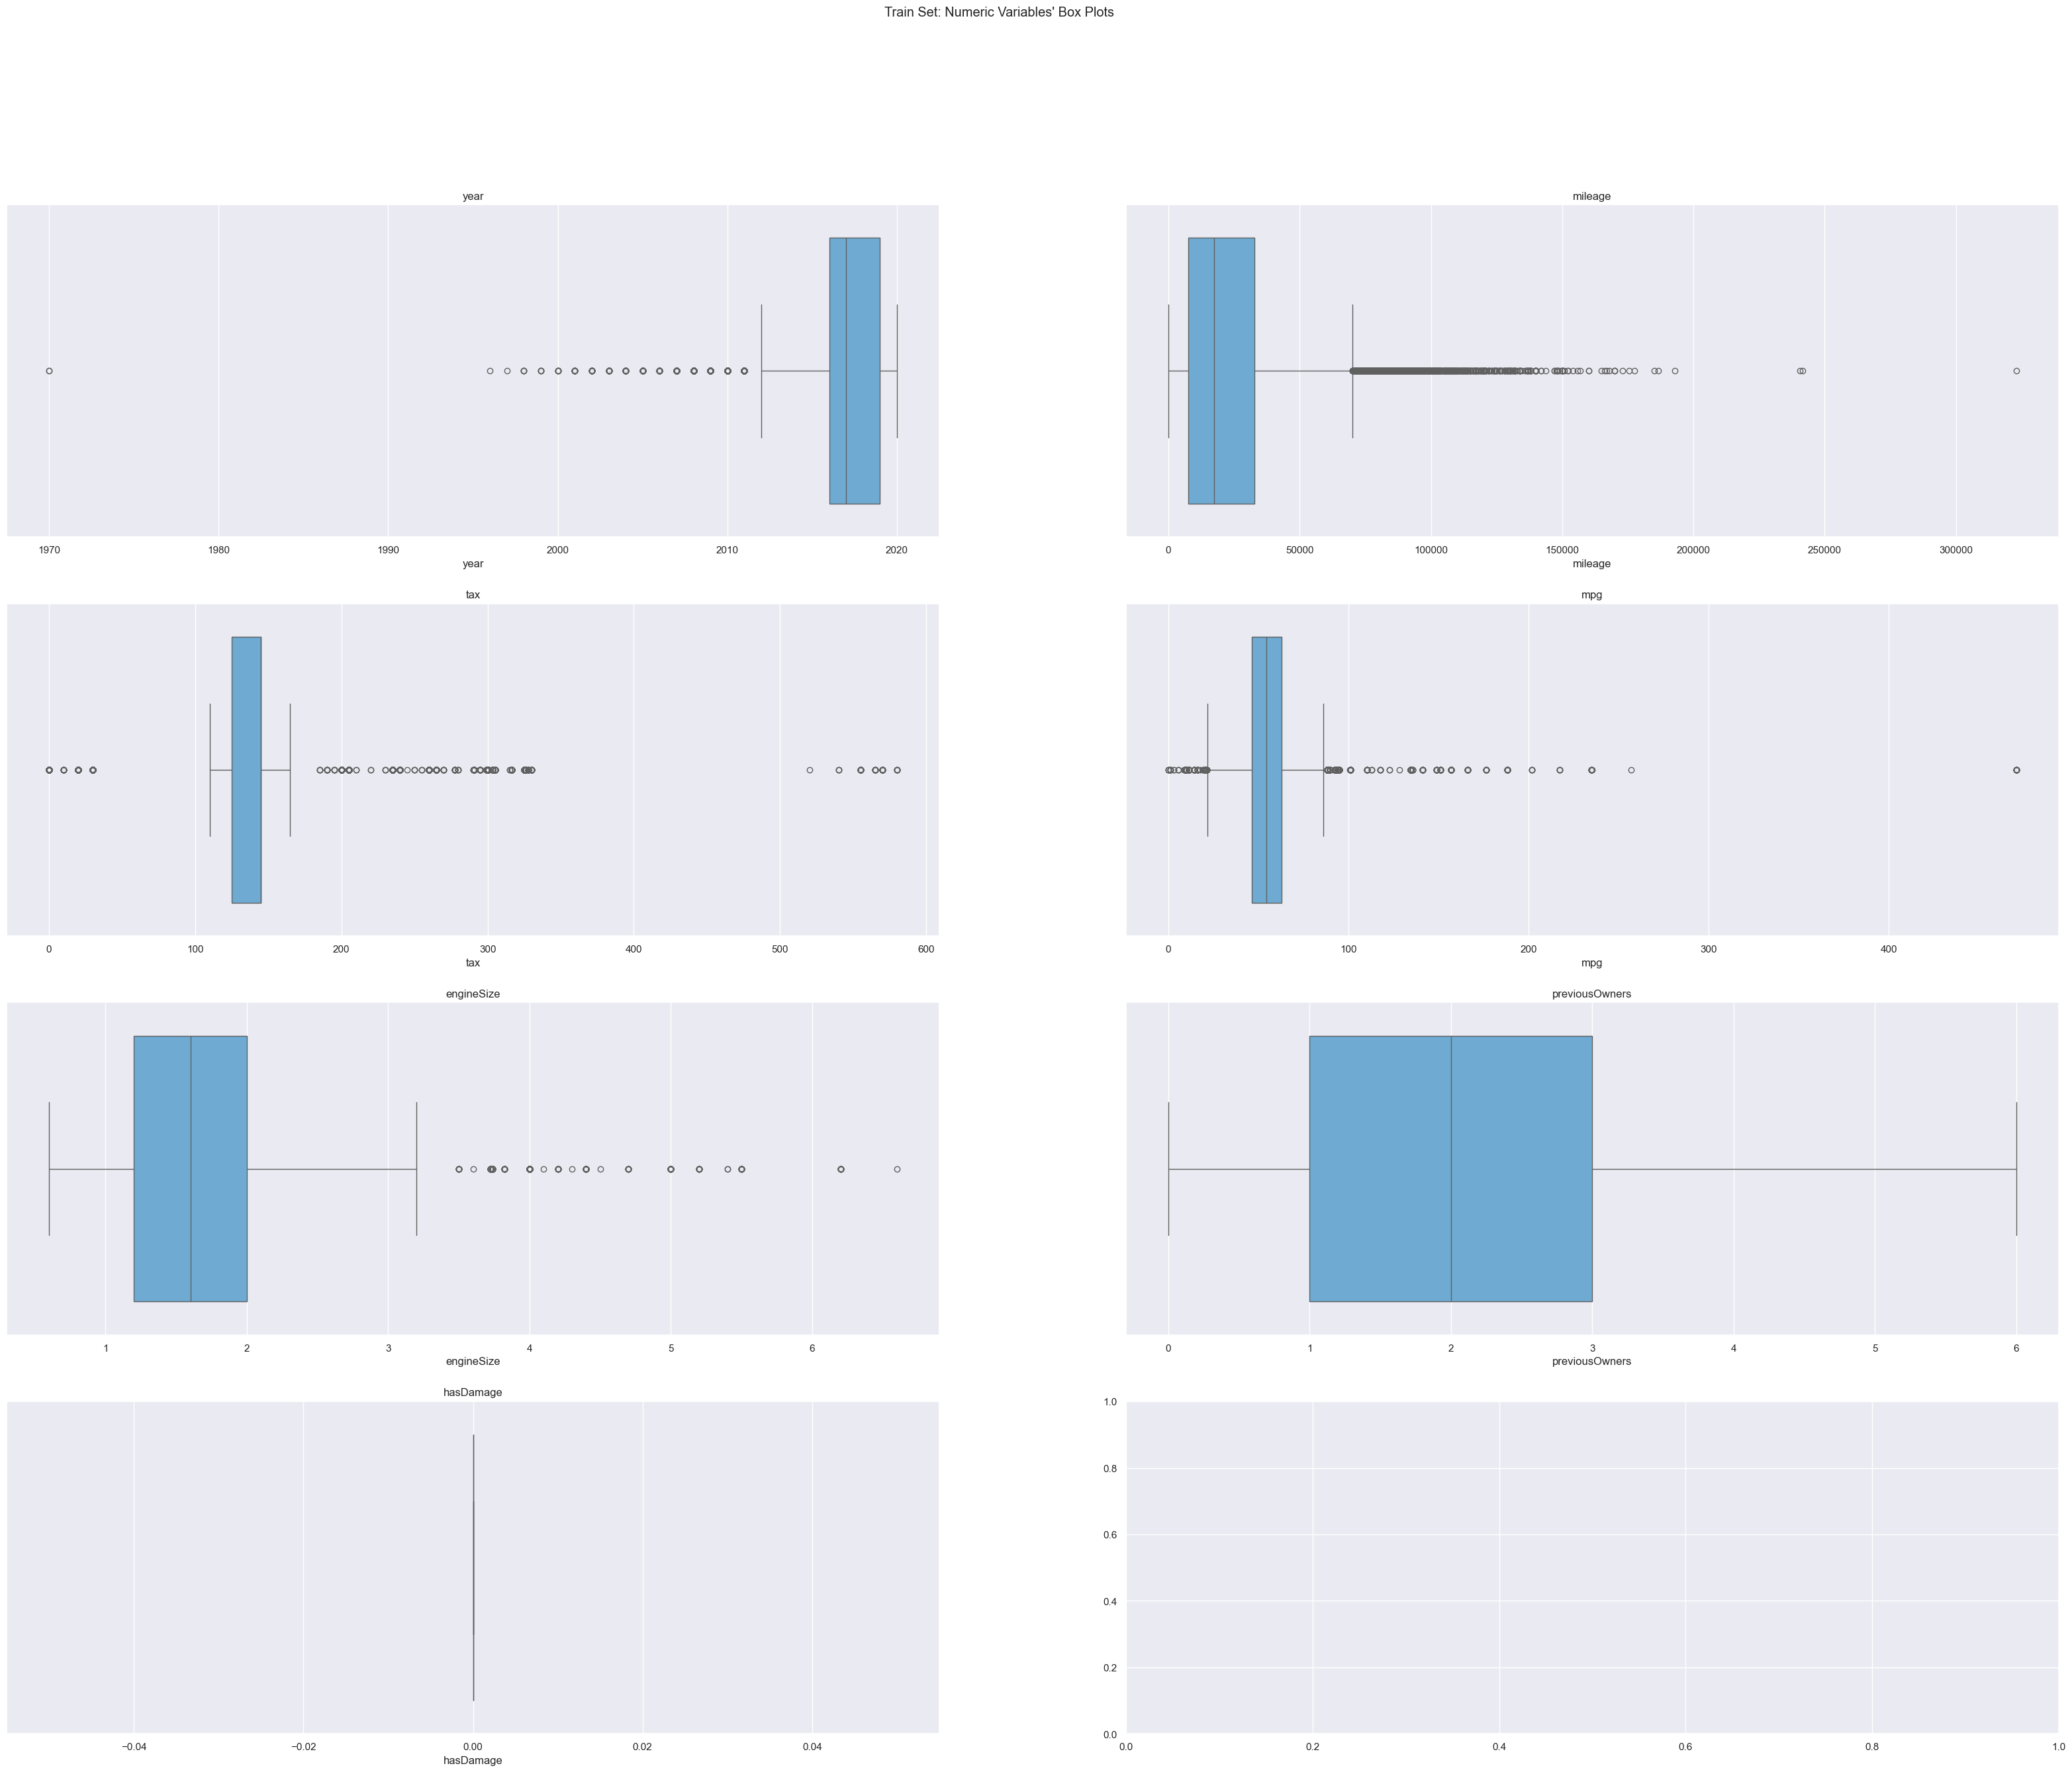

In [790]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_train, metric_features, title="Train Set: Numeric Variables' Box Plots")

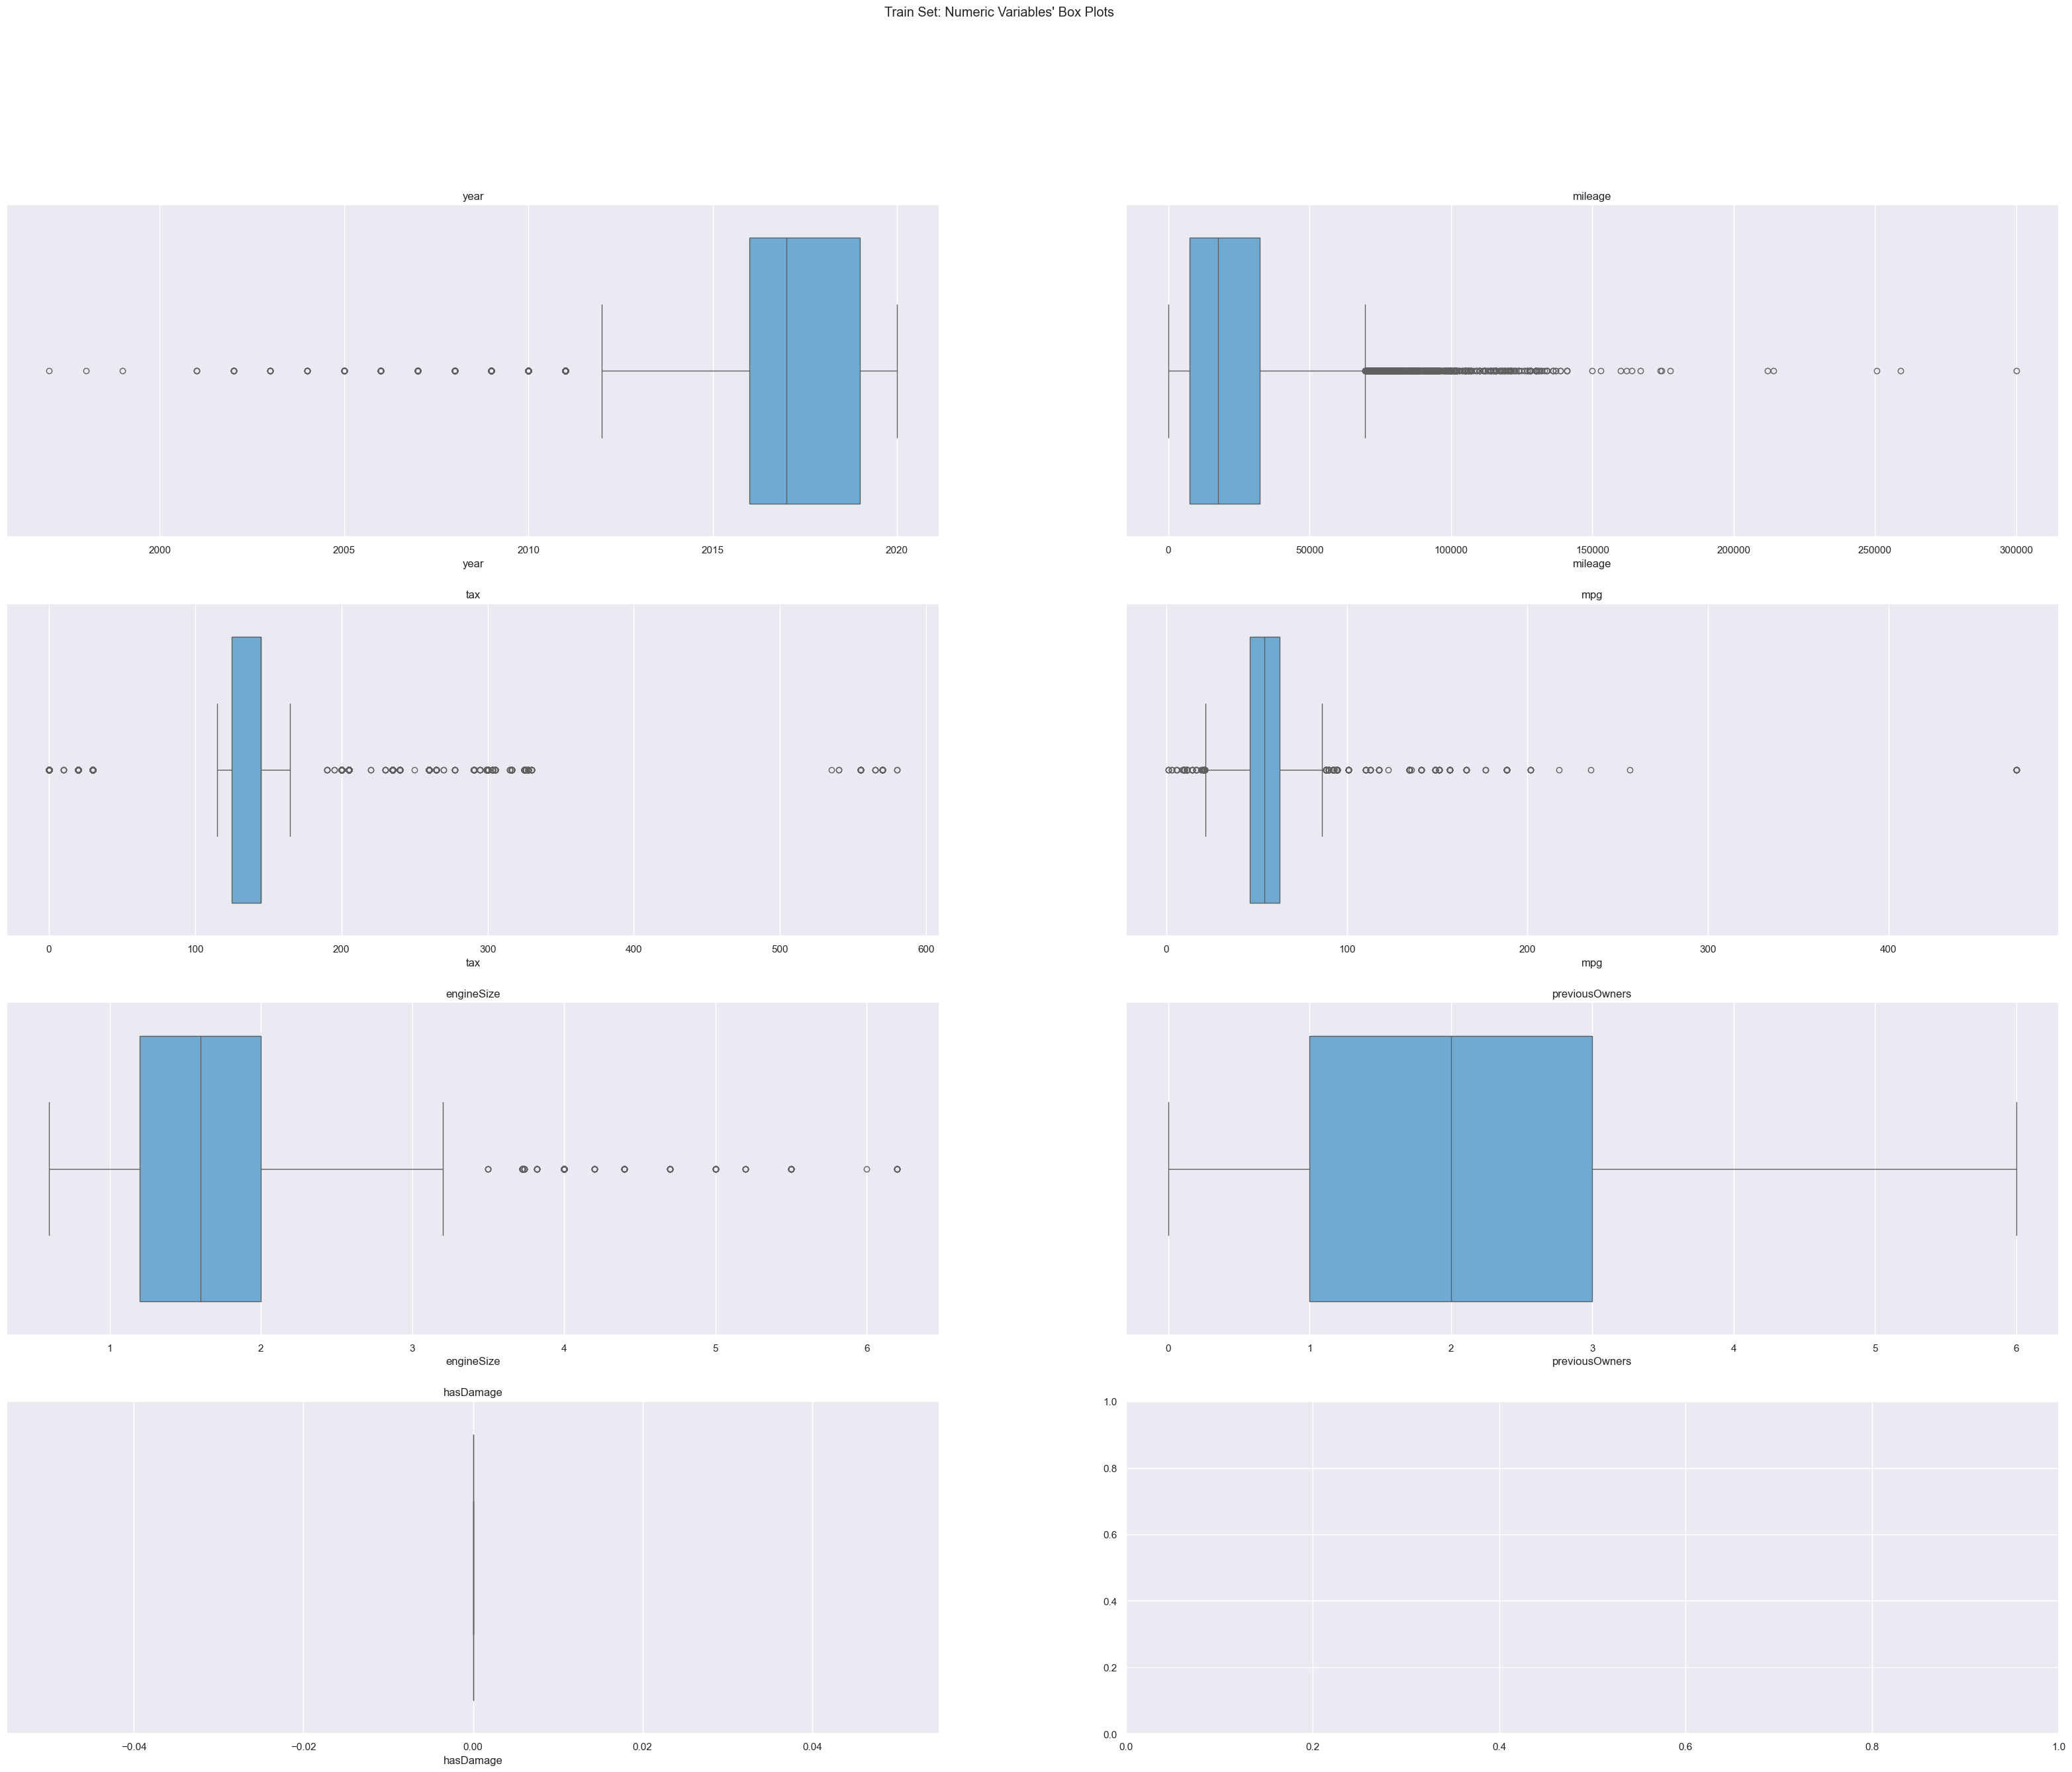

In [791]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_val, metric_features, title="Train Set: Numeric Variables' Box Plots")

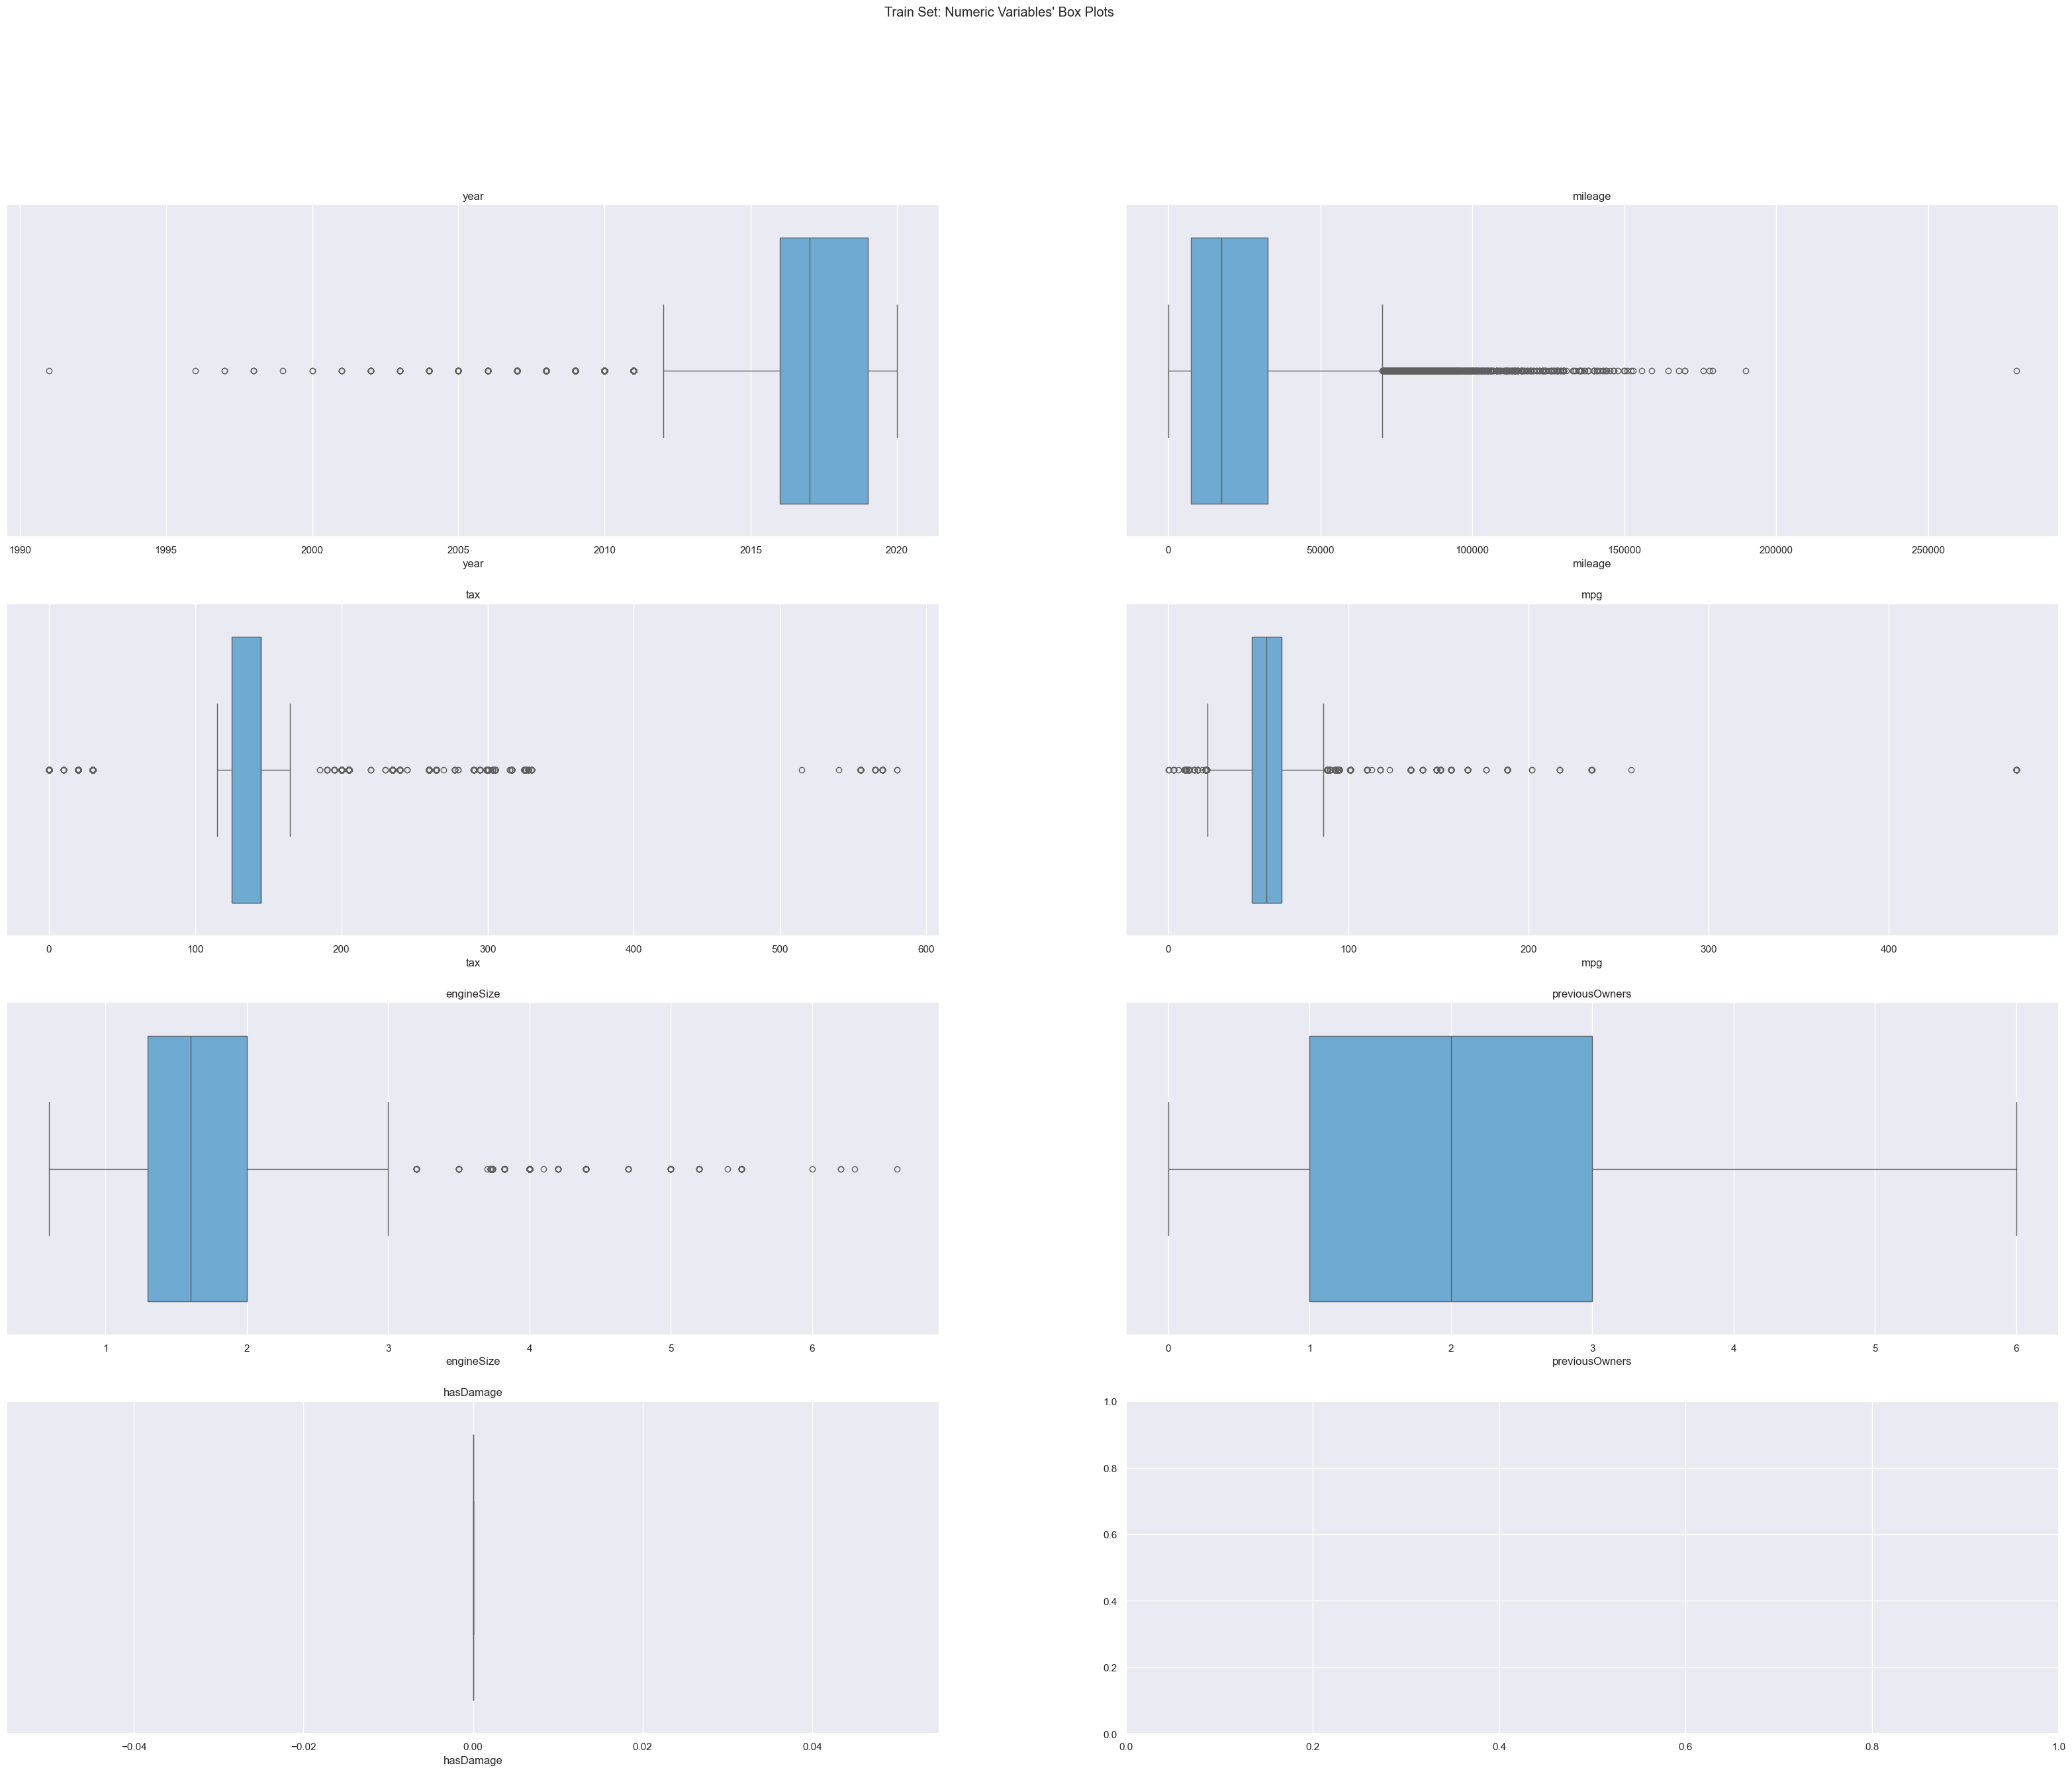

In [792]:
#checking outliers again after handling incoherencies on test_data
plot_multiple_boxplots(test_data, metric_features, title="Train Set: Numeric Variables' Box Plots")

**Year**

In [793]:
X_train[X_train['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
62732,Opel,Zafira,1970,Manual,37357.0,NaN,200.0,42.2,NaN,2,0
35769,Mercedes,M Class,1970,Automatic,14000.0,Diesel,305.0,39.2,NaN,3,0


In [794]:
X_val[X_val['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,


In [795]:
test_data[test_data['year'] < 1995]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
94627,Mercedes,C Class,1991,Automatic,170000.0,Petrol,NaN,NaN,3.0,4,0


In [796]:
#replacing years before 1995 by missing values for X_train and test_data
X_train.loc[X_train["year"] < 1995, "year"] = np.nan
test_data.loc[test_data["year"] < 1995, "year"] = np.nan

**Mileage**

In [797]:
X_train[X_train['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
58385,Opel,Astra,2008,Manual,186500.0,Petrol,260.0,36.7,1.8,1,0
45553,Mercedes,C Class,2012,Automatic,170000.0,Diesel,145.0,54.3,2.1,4,0
7038,Audi,A3,2009,Manual,152034.0,Diesel,150.0,55.4,1.9,4,0
19562,Ford,Focus,2003,Manual,177644.0,Petrol,200.0,41.5,1.6,2,0
45795,Mercedes,C Class,2008,Automatic,170000.0,Diesel,NaN,NaN,2.1,3,0
67297,VW,Golf,2009,Manual,193000.0,Diesel,160.0,52.3,2.0,3,0
41580,Mercedes,C Class,2012,Automatic,170000.0,Diesel,NaN,NaN,2.1,2,0
4692,Audi,A6,2008,Manual,323000.0,Diesel,200.0,44.1,2.0,1,0
12289,BMW,3 Series,2010,Manual,156800.0,Diesel,125.0,58.9,2.0,4,0


In [798]:
X_val[X_val['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
48042,Skoda,Octavia,2010,Manual,250650.0,Diesel,125.0,57.6,1.9,1,0
74387,VW,Caravelle,2012,NaN,212000.0,Diesel,325.0,34.4,2.0,2,0
23427,Ford,Focus,2003,Manual,177644.0,Petrol,NaN,NaN,1.6,4,0
21764,Ford,Galaxy,2008,Manual,174000.0,Diesel,220.0,44.8,1.8,4,0
9978,BMW,X5,2012,Automatic,214000.0,Diesel,300.0,37.7,3.0,1,0
9808,BMW,3 Series,<NA>,Manual,162000.0,Diesel,205.0,49.6,2.0,0,0
45370,Mercedes,V Class,2010,Automatic,259000.0,Diesel,540.0,30.7,3.0,1,0
66971,VW,Golf,2010,Manual,164000.0,Diesel,145.0,58.9,2.0,2,0
46713,Mercedes,C Class,2007,Automatic,160000.0,Diesel,NaN,NaN,2.2,4,0


In [799]:
test_data[test_data['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
78147,Audi,Q5,2011,Manual,168017.0,Diesel,200.0,42.10000,2.0,0,0
91517,Mercedes,C Class,2006,Automatic,153000.0,Petrol,300.0,33.60000,1.8,3,0
102018,Opel,Astra,2001,Manual,159000.0,Petrol,235.0,40.40000,1.6,4,0
81844,BMW,5 Series,2010,Automatic,164500.0,Diesel,140.0,53.30000,2.0,3,0
94627,Mercedes,C Class,<NA>,Automatic,170000.0,Petrol,NaN,NaN,3.0,4,0
100290,Opel,Zafira,2013,Manual,279000.0,Diesel,150.0,55.40000,1.7,3,0
80858,BMW,5 Series,2013,Automatic,178987.0,Hybrid,190.0,40.40000,3.0,3,0
106256,VW,Caravelle,2006,Manual,178000.0,Diesel,325.0,34.40000,2.5,0,0
80355,BMW,3 Series,2011,Manual,190000.0,Diesel,20.0,68.90000,2.0,0,0


In [800]:
#replacing mileages higher than 150000 by missing values
X_train.loc[X_train["mileage"] > 150000, "year"] = np.nan
X_val.loc[X_val["mileage"] > 150000, "year"] = np.nan
test_data.loc[test_data["mileage"] > 150000, "year"] = np.nan

**Tax**

In [801]:
X_train[X_train['tax'] < 50]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
74356,VW,Golf,2016,Semi-Auto,19432.0,Diesel,30.0,62.80000,2.0,3,0
75498,VW,Polo,2016,Semi-Auto,8695.0,Petrol,20.0,60.10000,1.2,2,0
51358,Toyota,Yaris,2017,Automatic,32994.0,Petrol,30.0,55.00000,1.3,2,0
2043,Audi,A1,2016,Semi-Auto,33435.0,Petrol,30.0,70.60000,1.4,0,0
166,Audi,A5,2014,Manual,30884.0,Diesel,30.0,60.10000,2.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
28583,Ford,B-MAX,2013,Manual,37058.0,NaN,30.0,27.70949,1.0,3,0
31202,Ford,Focus,2017,Manual,13000.0,Petrol,20.0,61.40000,1.0,4,0
2492,Audi,A4,2016,Automatic,28325.0,Diesel,0.0,72.40000,2.0,3,0


- Since the number of cars with *tax* less than 100 is large, these we will not be changed. 

In [802]:
#the same as 400
X_train[X_train['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
41531,Mercedes,SL CLASS,2016,Automatic,6200.0,Petrol,555.0,28.0,5.5,4,<NA>
44516,Mercedes,SL CLASS,2010,Automatic,79000.0,Petrol,555.0,29.1,3.5,4,0
54636,Toyota,Land Cruiser,2006,Automatic,113000.0,Diesel,555.0,31.4,3.0,0,0
37494,Mercedes,M Class,2010,Automatic,128000.0,Diesel,555.0,32.5,3.0,1,0
52900,Toyota,Land Cruiser,2014,Automatic,60000.0,Diesel,540.0,29.7,4.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2116,Audi,RS6,2014,Automatic,59894.0,Petrol,555.0,28.8,NaN,4,0
56446,Opel,Antara,2007,Automatic,99500.0,Diesel,565.0,32.8,2.0,3,0
35606,Mercedes,M Class,2009,Automatic,59000.0,Diesel,555.0,30.4,3.0,2,0


In [803]:
X_val[X_val['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
2522,Audi,Q7,2009,Automatic,136000.0,NaN,540.0,31.0,3.0,1,0
12995,BMW,M3,2013,Automatic,58125.0,Petrol,570.0,25.2,4.0,3,0
39852,Mercedes,S Class,2010,Automatic,38000.0,Petrol,570.0,19.5,6.2,4,0
921,Audi,RS6,2014,Automatic,58000.0,Petrol,555.0,28.8,4.0,2,0
41484,Mercedes,S Class,2016,Automatic,14000.0,Petrol,555.0,28.0,5.5,4,0
73570,VW,Touareg,2007,Automatic,122965.0,Diesel,580.0,26.9,3.0,1,0
45503,Mercedes,GL Class,2007,Automatic,104000.0,Diesel,570.0,28.8,3.0,2,0
39351,NaN,GLE Class,2015,Automatic,13212.0,Petrol,570.0,23.7,NaN,2,0
34980,Mercedes,S Class,2014,Automatic,26000.0,Petrol,555.0,28.0,5.5,1,0


In [804]:
test_data[test_data['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
95966,Mercedes,S Class,2011,Automatic,66000.000000,Petrol,570.0,24.6,3.2,0,0
94732,Mercedes,S Class,2015,Automatic,23156.000000,Petrol,555.0,28.0,5.5,2,0
80066,BMW,M6,2016,Semi-Auto,26642.000000,Petrol,555.0,28.5,NaN,1,0
79095,Audi,A8,2015,Automatic,30306.000000,Petrol,570.0,25.0,6.3,2,0
80790,BMW,M5,<NA>,Automatic,55241.000000,Petrol,555.0,28.5,4.4,3,0
79753,BMW,M5,2015,Semi-Auto,42932.000000,Petrol,555.0,28.5,4.4,1,0
78115,Audi,A8,2017,Automatic,16975.000000,Petrol,555.0,28.2,4.0,0,0
103312,Opel,Insignia,2012,Manual,48490.000000,Petrol,555.0,25.9,2.8,2,0
95550,Mercedes,SL CLASS,2016,Automatic,19425.000000,NaN,555.0,NaN,5.5,0,0


In [805]:
#replacing taxes higher than 350 by missing values
X_train.loc[X_train["tax"] > 350, "year"] = np.nan
X_val.loc[X_val["tax"] > 350, "year"] = np.nan
test_data.loc[test_data["tax"] > 350, "year"] = np.nan

**Mpg**

In [806]:
X_train[X_train['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
11068,BMW,I3,2016,NaN,43695.0,Hybrid,0.0,470.8,NaN,1,0
14531,BMW,I3,2017,Automatic,36429.0,Hybrid,0.0,470.8,NaN,2,0
12332,BMW,I3,2015,Automatic,65800.0,Hybrid,0.0,470.8,NaN,3,0
9643,BMW,I3,2017,Automatic,20929.0,Hybrid,135.0,470.8,NaN,2,0
12640,BMW,I3,2017,Automatic,23956.0,NaN,135.0,470.8,0.6,1,0
12269,BMW,I3,2017,Automatic,26965.0,Hybrid,140.0,470.8,NaN,3,0
13378,BMW,I3,2015,Automatic,9886.0,Hybrid,0.0,470.8,NaN,0,0
11962,BMW,I3,2017,Automatic,21025.0,Hybrid,0.0,470.8,NaN,0,0
10327,BMW,I3,2014,Automatic,42479.0,Hybrid,0.0,470.8,NaN,2,0


In [807]:
X_val[X_val['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
11589,BMW,I3,2016,Automatic,25269.0,NaN,0.0,470.8,0.6,0,0
8497,BMW,I3,2017,Automatic,24041.0,Hybrid,0.0,470.8,NaN,3,0
12090,BMW,I3,2016,Automatic,8421.0,Hybrid,0.0,470.8,NaN,4,0
10967,BMW,I3,2016,Automatic,41063.0,NaN,0.0,470.8,0.6,6,0
8993,BMW,I3,2016,Automatic,9990.0,NaN,0.0,470.8,NaN,0,0
10133,BMW,I3,2017,Automatic,NaN,NaN,0.0,470.8,0.6,4,0
9196,BMW,I3,2016,Automatic,19995.0,Hybrid,0.0,470.8,NaN,3,0
13075,BMW,I3,2015,Automatic,33931.0,Hybrid,0.0,470.8,NaN,4,0


In [808]:
test_data[test_data['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
80758,BMW,I3,2016,Automatic,59945.0,Hybrid,0.0,470.8,NaN,3,0
80669,BMW,I3,2017,Automatic,28169.0,Hybrid,0.0,470.8,NaN,3,0
80184,BMW,I3,2017,Automatic,41949.0,Hybrid,140.0,470.8,NaN,4,0
81032,BMW,I3,2017,Automatic,33021.0,Hybrid,0.0,470.8,NaN,3,0
79921,BMW,I3,2017,Automatic,50867.0,NaN,135.0,470.8,0.600000,2,0
82073,BMW,I3,2015,Automatic,59000.0,NaN,0.0,470.8,0.600000,1,0
80882,BMW,I3,2017,Automatic,10900.0,Hybrid,140.0,470.8,NaN,2,0
80277,BMW,I3,2017,Automatic,26139.0,Hybrid,135.0,470.8,NaN,2,0
79191,BMW,I3,2017,Automatic,17338.0,Hybrid,135.0,470.8,NaN,0,0


- All mpg > 300 are from BMW I3 and they all have the same mpg.

In [809]:
#replacing mpg higher than 300 by missing values
X_train.loc[X_train["mpg"] > 300, "year"] = np.nan
X_val.loc[X_val["mpg"] > 300, "year"] = np.nan
test_data.loc[test_data["mpg"] > 300, "year"] = np.nan

**EngineSize**

In [810]:
X_train[X_train['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
41531,Mercedes,SL CLASS,<NA>,Automatic,6200.0,Petrol,555.000000,28.0,5.5,4,<NA>
35538,NaN,C Class,<NA>,Semi-Auto,49964.0,Petrol,326.028233,NaN,6.2,3,0
2487,Audi,R8,2019,Semi-Auto,7800.0,Petrol,145.000000,21.4,5.2,4,0
45626,Mercedes,SL CLASS,<NA>,Semi-Auto,21681.0,Petrol,565.000000,28.0,5.5,1,0
37895,Mercedes,GLE Class,2019,Semi-Auto,11545.0,Petrol,145.000000,23.9,5.5,2,0
35290,Mercedes,C Class,<NA>,Automatic,56444.0,Petrol,580.000000,23.5,6.2,0,0
39752,Mercedes,C Class,2014,Automatic,56444.0,Petrol,NaN,NaN,6.2,3,0
2022,Audi,R8,2019,Automatic,8175.0,Petrol,145.000000,21.6,5.2,4,0
40976,Mercedes,GLE Class,2019,Semi-Auto,9.0,Petrol,145.000000,23.7,5.5,1,0


In [811]:
X_val[X_val['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
6647,Audi,R8,<NA>,Semi-Auto,4000.000000,Petrol,145.0,21.4,5.2,4,0
44293,Mercedes,S Class,1998,Automatic,43534.000000,Petrol,NaN,23.3,6.0,2,0
44376,Mercedes,SL CLASS,2019,Semi-Auto,3728.000000,Petrol,145.0,28.0,5.5,1,0
39852,Mercedes,S Class,<NA>,Automatic,38000.000000,Petrol,570.0,19.5,6.2,4,0
46372,Mercedes,C Class,2013,Semi-Auto,49964.000000,Petrol,NaN,23.0,6.2,3,0
41484,Mercedes,S Class,<NA>,Automatic,14000.000000,Petrol,555.0,28.0,5.5,4,0
46668,Mercedes,GLE Class,2017,Automatic,7000.000000,Petrol,145.0,29.5,5.5,3,0
34980,Mercedes,S Class,<NA>,Automatic,26000.000000,Petrol,555.0,28.0,5.5,1,0
36076,Mercedes,SL CLASS,2017,Semi-Auto,NaN,Petrol,145.0,28.0,5.5,0,0


In [812]:
test_data[test_data['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners,hasDamage
carID,,,,,,,,,,,
94732,Mercedes,S Class,<NA>,Automatic,23156.000000,Petrol,555.0,28.0,5.5,2,0
79095,Audi,A8,<NA>,Automatic,30306.000000,Petrol,570.0,25.0,6.3,2,0
95550,Mercedes,SL CLASS,<NA>,Automatic,19425.000000,NaN,555.0,NaN,5.5,0,0
92738,Mercedes,CLS Class,<NA>,Automatic,46283.000000,Petrol,555.0,28.5,5.5,3,0
91008,Mercedes,GL Class,<NA>,Automatic,55000.000000,Petrol,570.0,23.0,5.5,4,<NA>
76804,Audi,R8,2020,Semi-Auto,333.000000,Petrol,145.0,21.4,5.2,1,0
94754,Mercedes,C Class,2013,Automatic,41866.000000,Petrol,NaN,NaN,6.2,1,0
77563,Audi,R8,2019,Automatic,11936.000000,Petrol,145.0,21.4,5.2,0,0
95730,Mercedes,SL CLASS,<NA>,Semi-Auto,86705.854885,Petrol,565.0,28.5,5.5,3,0


In [813]:
#replacing mileages higher than 150000 by missing values
X_train.loc[X_train["engineSize"] > 5, "year"] = np.nan
X_val.loc[X_val["engineSize"] > 5, "year"] = np.nan
test_data.loc[test_data["engineSize"] > 5, "year"] = np.nan

### 4.7. Treating Missing Values

#### 4.7.1. Numerical Variables 

**KNN Imputer**

In [814]:
X_train[metric_features].isna().sum().sort_values(ascending=False)

tax               5658
mpg               5418
engineSize        1450
year              1440
mileage           1224
hasDamage         1094
previousOwners    1091
dtype: int64

In [815]:
X_val[metric_features].isna().sum().sort_values(ascending=False)

tax               2495
mpg               2416
year               625
engineSize         581
mileage            552
previousOwners     459
hasDamage          454
dtype: int64

In [816]:
test_data[metric_features].isna().sum().sort_values(ascending=False)

tax               3469
mpg               3305
year               927
mileage            859
engineSize         854
previousOwners     597
hasDamage          597
dtype: int64

- Most of our variables are MAR (missing at random), which means that missingness depends on known variables. For example, we can imply that milage depends on brand, year and engine size; mpg depends on fuel type and model; tax depends on fuel type and year, etc.
- This means that the "correct" value for a missing record would not reply on the global mean, but depends on similiar cars. Therefore, the KNN imputer method is a good solution for this type of problem since it is capable of dealing with MAR, while capturing non linear relationships. 

In [817]:
#scalling X_train and X_val since KNN imputer uses distances

#numerical variables whose missing values need to be filled
numeric_cols = ['tax', 'mpg', 'mileage', 'engineSize', 'hasDamage', 'previousOwners', 'year']
scaler = MinMaxScaler()

# fitting the scaler only on training dataset (to avoid leakage)
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# transforming validation dataset using the same scaling
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])


In [818]:
knn = KNNImputer(n_neighbors=5, weights='distance')

X_train[numeric_cols] = knn.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = knn.transform(X_val[numeric_cols])
test_data[numeric_cols] = knn.transform(test_data[numeric_cols])

In [819]:
X_train[metric_features].isna().sum().sort_values(ascending=False)

year              0
mileage           0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64

In [820]:
X_val[metric_features].isna().sum().sort_values(ascending=False)

year              0
mileage           0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64

In [821]:
test_data[metric_features].isna().sum().sort_values(ascending=False)

year              0
mileage           0
tax               0
mpg               0
engineSize        0
previousOwners    0
hasDamage         0
dtype: int64

#### 4.7.2. Categorical Variables

**Filling with the mode**

In [822]:
X_train[non_metric_features].isna().sum().sort_values(ascending=False)

transmission    1637
model           1175
fuelType        1142
Brand           1053
dtype: int64

In [823]:
X_val[non_metric_features].isna().sum().sort_values(ascending=False)

transmission    626
fuelType        536
model           529
Brand           468
dtype: int64

In [824]:
test_data[non_metric_features].isna().sum().sort_values(ascending=False)

transmission    971
fuelType        738
model           713
Brand           649
dtype: int64

In [825]:
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train.loc[:, non_metric_features] = cat_imputer.fit_transform(X_train[non_metric_features])
X_val.loc[:, non_metric_features] = cat_imputer.transform(X_val[non_metric_features])
test_data.loc[:, non_metric_features] = cat_imputer.transform(test_data[non_metric_features])

In [826]:
X_train[non_metric_features].isna().sum().sort_values(ascending=False)

Brand           0
model           0
transmission    0
fuelType        0
dtype: int64

In [827]:
X_val[non_metric_features].isna().sum().sort_values(ascending=False)

Brand           0
model           0
transmission    0
fuelType        0
dtype: int64

In [828]:
test_data[non_metric_features].isna().sum().sort_values(ascending=False)

Brand           0
model           0
transmission    0
fuelType        0
dtype: int64

### 4.8. Feature Engineering

#### 4.8.1. Creating New Variables

In [829]:
X_train['engineEfficiency'] = X_train['mpg'] / X_train['engineSize']
X_val['engineEfficiency'] = X_val['mpg'] / X_val['engineSize']
test_data['engineEfficiency'] = test_data['mpg'] / test_data['engineSize']

#### 4.8.2. Encoding Categorical Features

- Frequency encoding is used to transform the variables Brand and model into numerical, as these have a high cardinality, while transmission and fuelType was transformed into dummy variables.

In [830]:
freq_encoding_brand = X_train['Brand'].value_counts()
mean_freq_brand = freq_encoding_brand.mean()
X_train['brand_encoded'] = X_train['Brand'].map(freq_encoding_brand)
X_val['brand_encoded'] = X_val['Brand'].map(freq_encoding_brand).fillna(mean_freq_brand)
test_data['brand_encoded'] = test_data['Brand'].map(freq_encoding_brand).fillna(mean_freq_brand)


In [831]:
freq_encoding_model = X_train['model'].value_counts()
mean_freq_model = freq_encoding_model.mean()
X_train['model_encoded'] = X_train['model'].map(freq_encoding_model)
X_val['model_encoded'] = X_val['model'].map(freq_encoding_model).fillna(mean_freq_model)
test_data['model_encoded'] = test_data['model'].map(freq_encoding_model).fillna(mean_freq_model)

In [832]:
freq_encoding_transmission = X_train['transmission'].value_counts()
mean_freq_transmission = freq_encoding_transmission.mean()
X_train['transmission_encoded'] = X_train['transmission'].map(freq_encoding_transmission)
X_val['transmission_encoded'] = X_val['transmission'].map(freq_encoding_transmission).fillna(mean_freq_transmission)
test_data['transmission_encoded'] = test_data['transmission'].map(freq_encoding_transmission).fillna(mean_freq_transmission)

- We observed that the fuelType variable contained, only 4 Electric cars, which is an extremely low representation for a category, and 46 rows defined as "other". To prevent overfitting and unstable coefficients, these categories were grouped together into the Other class.

In [833]:
print(X_train["fuelType"].value_counts())
print(X_val["fuelType"].value_counts())
print(test_data["fuelType"].value_counts())

fuelType
Petrol      29738
Diesel      21535
Hybrid       1540
Electric        4
Name: count, dtype: int64
fuelType
Petrol    12796
Diesel     9230
Hybrid      679
Name: count, dtype: int64
fuelType
Petrol      18235
Diesel      13395
Hybrid        936
Electric        1
Name: count, dtype: int64


In [834]:
rare_fuels = ['Electric', 'Other']
X_train['fuelType'] = X_train['fuelType'].replace(rare_fuels, 'Other')
X_val['fuelType'] = X_val['fuelType'].replace(rare_fuels, 'Other')
test_data['fuelType'] = test_data['fuelType'].replace(rare_fuels, 'Other')

freq_encoding_fuel = X_train['fuelType'].value_counts() 
mean_freq_fuel = freq_encoding_fuel.mean()
X_train['fuelType_encoded'] = X_train['fuelType'].map(freq_encoding_fuel)
X_val['fuelType_encoded'] = X_val['fuelType'].map(freq_encoding_fuel).fillna(mean_freq_fuel)
test_data['fuelType_encoded'] = test_data['fuelType'].map(freq_encoding_fuel).fillna(mean_freq_fuel)

In [835]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52817 entries, 42520 to 15659
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 52817 non-null  object 
 1   model                 52817 non-null  object 
 2   year                  52817 non-null  float64
 3   transmission          52817 non-null  object 
 4   mileage               52817 non-null  float64
 5   fuelType              52817 non-null  object 
 6   tax                   52817 non-null  float64
 7   mpg                   52817 non-null  float64
 8   engineSize            52817 non-null  float64
 9   previousOwners        52817 non-null  float64
 10  hasDamage             52817 non-null  float64
 11  engineEfficiency      52817 non-null  float64
 12  brand_encoded         52817 non-null  int64  
 13  model_encoded         52817 non-null  int64  
 14  transmission_encoded  52817 non-null  int64  
 15  fuelType_encoded    

In [836]:
X_val.isna().sum().sort_values(ascending=False)

Brand                   0
model                   0
year                    0
transmission            0
mileage                 0
fuelType                0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

In [837]:
test_data.isna().sum().sort_values(ascending=False)

Brand                   0
model                   0
year                    0
transmission            0
mileage                 0
fuelType                0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

In [838]:
X_train = X_train.drop(['Brand', 'model', 'transmission', 'fuelType'], axis=1)
X_val = X_val.drop(['Brand', 'model', 'transmission', 'fuelType'], axis=1)
test_data = test_data.drop(['Brand', 'model', 'transmission', 'fuelType'], axis=1)

In [839]:
# ensuring that y_train has the same rows X_train
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (52817, 12)
y_train shape: (52817,)


### 4.9. Scaling

In [840]:
#checking if the variable created has some infinite values
print(np.isinf(X_train["engineEfficiency"]).sum())
print(np.isinf(X_val["engineEfficiency"]).sum())
print(np.isinf(test_data["engineEfficiency"]).sum())

1
3
3


In [841]:
X_train.head()

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
carID,,,,,,,,,,,,
42520,0.916667,0.004040,0.250000,0.088148,0.400000,0.500000,0.0,0.220370,8079,907,11750,21535
25115,0.791667,0.024152,0.106897,0.130544,0.166667,0.333333,0.0,0.783263,12149,5904,10456,29738
45113,0.875000,0.057257,0.249997,0.125823,0.250000,0.666667,0.0,0.503291,8079,3662,10456,21535
34623,0.916667,0.020690,0.258621,0.107052,0.133333,0.500000,0.0,0.802889,2366,96,30611,29738
66409,0.958333,0.039059,0.250000,0.080076,0.233333,0.500000,0.0,0.343185,7240,2322,10456,29738


In [842]:
#replace infinite by missing values
X_train = X_train.replace({"engineEfficiency": {np.inf: np.nan, -np.inf: np.nan}})
X_val = X_val.replace({"engineEfficiency": {np.inf: np.nan, -np.inf: np.nan}})
test_data = test_data.replace({"engineEfficiency": {np.inf: np.nan, -np.inf: np.nan}})


In [845]:
#fill the missing values using the mean
mean_engineEfficiency = X_train['engineEfficiency'].mean()
X_train['engineEfficiency'] = X_train['engineEfficiency'].fillna(mean_engineEfficiency)
X_val['engineEfficiency'] = X_val['engineEfficiency'].fillna(mean_engineEfficiency)
test_data['engineEfficiency'] = test_data['engineEfficiency'].fillna(mean_engineEfficiency)


In [846]:
X_train.isnull().sum()



year                    0
mileage                 0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

In [847]:
X_val.isnull().sum()


year                    0
mileage                 0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

In [848]:
test_data.isnull().sum()

year                    0
mileage                 0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

- We replaced the infinites by missing values and fill them because, if there were infinites in *engineEfficiency*, the scaled would not work. 

In [849]:
#variables that are not scalled yet
rest_var = ['year', 'brand_encoded', 'model_encoded', 'engineEfficiency', 'transmission_encoded', 'fuelType_encoded']

# fitting the scaler only on training dataset (to avoid leakage)
X_train[rest_var] = scaler.fit_transform(X_train[rest_var])

# transforming validation dataset using the same scaling
X_val[rest_var] = scaler.transform(X_val[rest_var])
test_data[rest_var] = scaler.transform(test_data[rest_var])

In [850]:
#checking if X_train and y_train have the same number of rows
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (52817, 12)
y_train shape: (52817,)


In [851]:
#checking if X_val and y_val have the same number of rows
print("X_val shape:", X_train.shape)
print("y_val shape:", y_train.shape)

X_val shape: (52817, 12)
y_val shape: (52817,)


In [852]:
test_data.isna().sum().sort_values(ascending=False)

year                    0
mileage                 0
tax                     0
mpg                     0
engineSize              0
previousOwners          0
hasDamage               0
engineEfficiency        0
brand_encoded           0
model_encoded           0
transmission_encoded    0
fuelType_encoded        0
dtype: int64

In [853]:
X_train.head()

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
carID,,,,,,,,,,,,
42520,0.916667,0.004040,0.250000,0.088148,0.400000,0.500000,0.0,0.014691,0.583972,0.153481,0.064202,0.724121
25115,0.791667,0.024152,0.106897,0.130544,0.166667,0.333333,0.0,0.052218,1.000000,1.000000,0.000000,1.000000
45113,0.875000,0.057257,0.249997,0.125823,0.250000,0.666667,0.0,0.033553,0.583972,0.620193,0.000000,0.724121
34623,0.916667,0.020690,0.258621,0.107052,0.133333,0.500000,0.0,0.053526,0.000000,0.016094,1.000000,1.000000
66409,0.958333,0.039059,0.250000,0.080076,0.233333,0.500000,0.0,0.022879,0.498211,0.393190,0.000000,1.000000


In [854]:
X_val.head()

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
carID,,,,,,,,,,,,
37025,0.833333,0.159319,0.051724,0.136364,0.166667,0.000000,0.0,0.054545,0.583972,0.620193,0.064202,0.724121
65090,0.791667,0.188852,0.275862,0.099021,0.133333,0.166667,0.0,0.049511,0.418890,0.069626,1.000000,1.000000
29197,0.916667,0.027362,0.250000,0.122557,0.066667,0.000000,0.0,0.122557,1.000000,1.000000,1.000000,1.000000
22100,0.958333,0.019254,0.250000,0.125106,0.066667,1.000000,0.0,0.125106,1.000000,1.000000,1.000000,1.000000
70417,0.958333,0.019220,0.250000,0.101742,0.066667,0.500000,0.0,0.101742,0.498211,0.025580,1.000000,1.000000


In [855]:
test_data.head()

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
carID,,,,,,,,,,,,
89856,0.791667,0.095044,0.353448,0.088148,0.166667,0.500000,0.0,0.035259,0.000000,0.042013,0.000000,1.000000
106581,0.875000,0.069102,0.258621,0.081138,0.233333,0.333333,0.0,0.023182,0.498211,0.147891,0.064202,1.000000
80886,0.833333,0.113904,0.215517,0.109176,0.150000,0.333333,0.0,0.048523,0.281509,0.095375,0.000000,1.000000
100174,0.958333,0.017127,0.250000,0.093670,0.100000,0.166667,0.0,0.062447,0.418890,0.046417,1.000000,1.000000
81376,0.958333,0.028040,0.258621,0.109176,0.233333,0.666667,0.0,0.031193,0.281509,0.161105,0.064202,0.724121


### 4.10. Feature Selection

#### 4.10.1. Filter Methods 

##### 4.10.1.1. Variance 

In [856]:
X_train.var()

year                    0.007879
mileage                 0.004441
tax                     0.011716
mpg                     0.003028
engineSize              0.008496
previousOwners          0.056817
hasDamage               0.000000
engineEfficiency        0.001849
brand_encoded           0.100776
model_encoded           0.094275
transmission_encoded    0.227831
fuelType_encoded        0.037672
dtype: float64

In [857]:
X_val.var()

year                    0.007589
mileage                 0.004382
tax                     0.011875
mpg                     0.003587
engineSize              0.008732
previousOwners          0.056617
hasDamage               0.000000
engineEfficiency        0.001998
brand_encoded           0.100944
model_encoded           0.095960
transmission_encoded    0.229328
fuelType_encoded        0.038094
dtype: float64

tirar: hasDamaged

##### 4.10.1.2. Spearman correlation

In [858]:
cor_spearman = X_train.corr(method ='spearman')
cor_spearman

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
year,1.000000,-0.786349,0.344423,-0.331607,-0.032967,-0.002582,NaN,-0.104565,-0.013858,-0.026802,-0.132559,0.099207
mileage,-0.786349,1.000000,-0.278626,0.333782,0.099331,0.006756,NaN,0.051585,0.013586,0.027735,0.111308,-0.190800
tax,0.344423,-0.278626,1.000000,-0.545282,0.139630,0.006155,NaN,-0.338651,-0.001992,-0.109357,-0.138703,0.164530
mpg,-0.331607,0.333782,-0.545282,1.000000,-0.185529,-0.009388,NaN,0.578332,0.080662,0.229279,0.177393,-0.336789
engineSize,-0.032967,0.099331,0.139630,-0.185529,1.000000,-0.003634,NaN,-0.881251,-0.086056,-0.219574,-0.486009,-0.598350
previousOwners,-0.002582,0.006756,0.006155,-0.009388,-0.003634,1.000000,NaN,-0.008768,0.006625,-0.000553,0.005425,0.002453
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engineEfficiency,-0.104565,0.051585,-0.338651,0.578332,-0.881251,-0.008768,NaN,1.000000,0.116686,0.274183,0.455505,0.347003
brand_encoded,-0.013858,0.013586,-0.001992,0.080662,-0.086056,0.006625,NaN,0.116686,1.000000,0.479611,0.106333,0.041089
model_encoded,-0.026802,0.027735,-0.109357,0.229279,-0.219574,-0.000553,NaN,0.274183,0.479611,1.000000,0.153206,0.162606


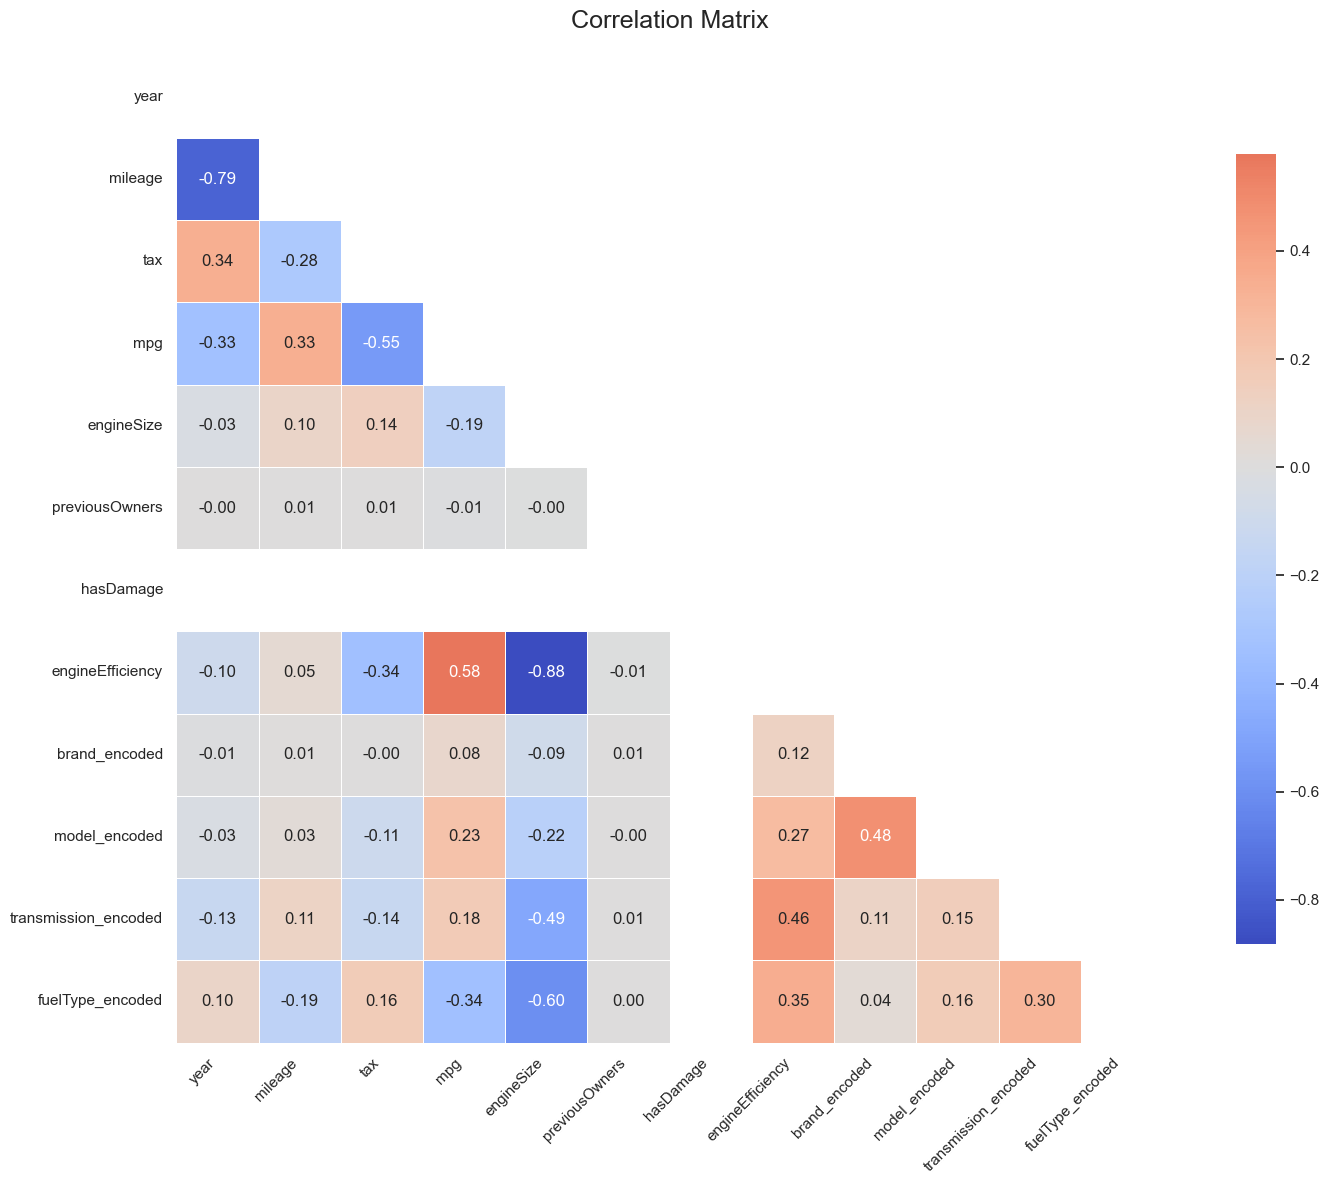

In [859]:
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Escolher um estilo de fundo branco
sns.set_theme(style="white")

# Criar a figura
plt.figure(figsize=(16, 12))

# Plotar o heatmap
sns.heatmap(
    cor_spearman,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

# Título e layout
plt.title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

tirar: 
- previousOwners (no relationship with any other)
- engineefficiency vs enginesize
- milage vs year
- hasDamaged

In [866]:
#tirar ou rever
cor_pearson = X_train.corr(method ='pearson')
cor_pearson

,year,mileage,tax,mpg,engineSize,previousOwners,hasDamage,engineEfficiency,brand_encoded,model_encoded,transmission_encoded,fuelType_encoded
year,1.000000,-0.692180,0.215558,-0.128046,-0.026235,-0.003898,NaN,-0.018065,-0.026555,-0.009952,-0.131724,0.050913
mileage,-0.692180,1.000000,-0.219918,0.143910,0.105176,0.006497,NaN,-0.043166,0.005091,0.000727,0.100411,-0.160586
tax,0.215558,-0.219918,1.000000,-0.254043,0.250493,0.003753,NaN,-0.243253,-0.002980,-0.070881,-0.192032,0.158918
mpg,-0.128046,0.143910,-0.254043,1.000000,-0.110673,-0.047053,NaN,0.546140,0.083515,0.182968,0.052739,-0.252626
engineSize,-0.026235,0.105176,0.250493,-0.110673,1.000000,-0.005855,NaN,-0.682433,-0.143669,-0.184302,-0.481773,-0.360269
previousOwners,-0.003898,0.006497,0.003753,-0.047053,-0.005855,1.000000,NaN,-0.025035,0.007625,-0.000262,0.006179,0.004150
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engineEfficiency,-0.018065,-0.043166,-0.243253,0.546140,-0.682433,-0.025035,NaN,1.000000,0.204119,0.273829,0.375221,0.233894
brand_encoded,-0.026555,0.005091,-0.002980,0.083515,-0.143669,0.007625,NaN,0.204119,1.000000,0.564182,0.168532,0.133278
model_encoded,-0.009952,0.000727,-0.070881,0.182968,-0.184302,-0.000262,NaN,0.273829,0.564182,1.000000,0.126294,0.120615


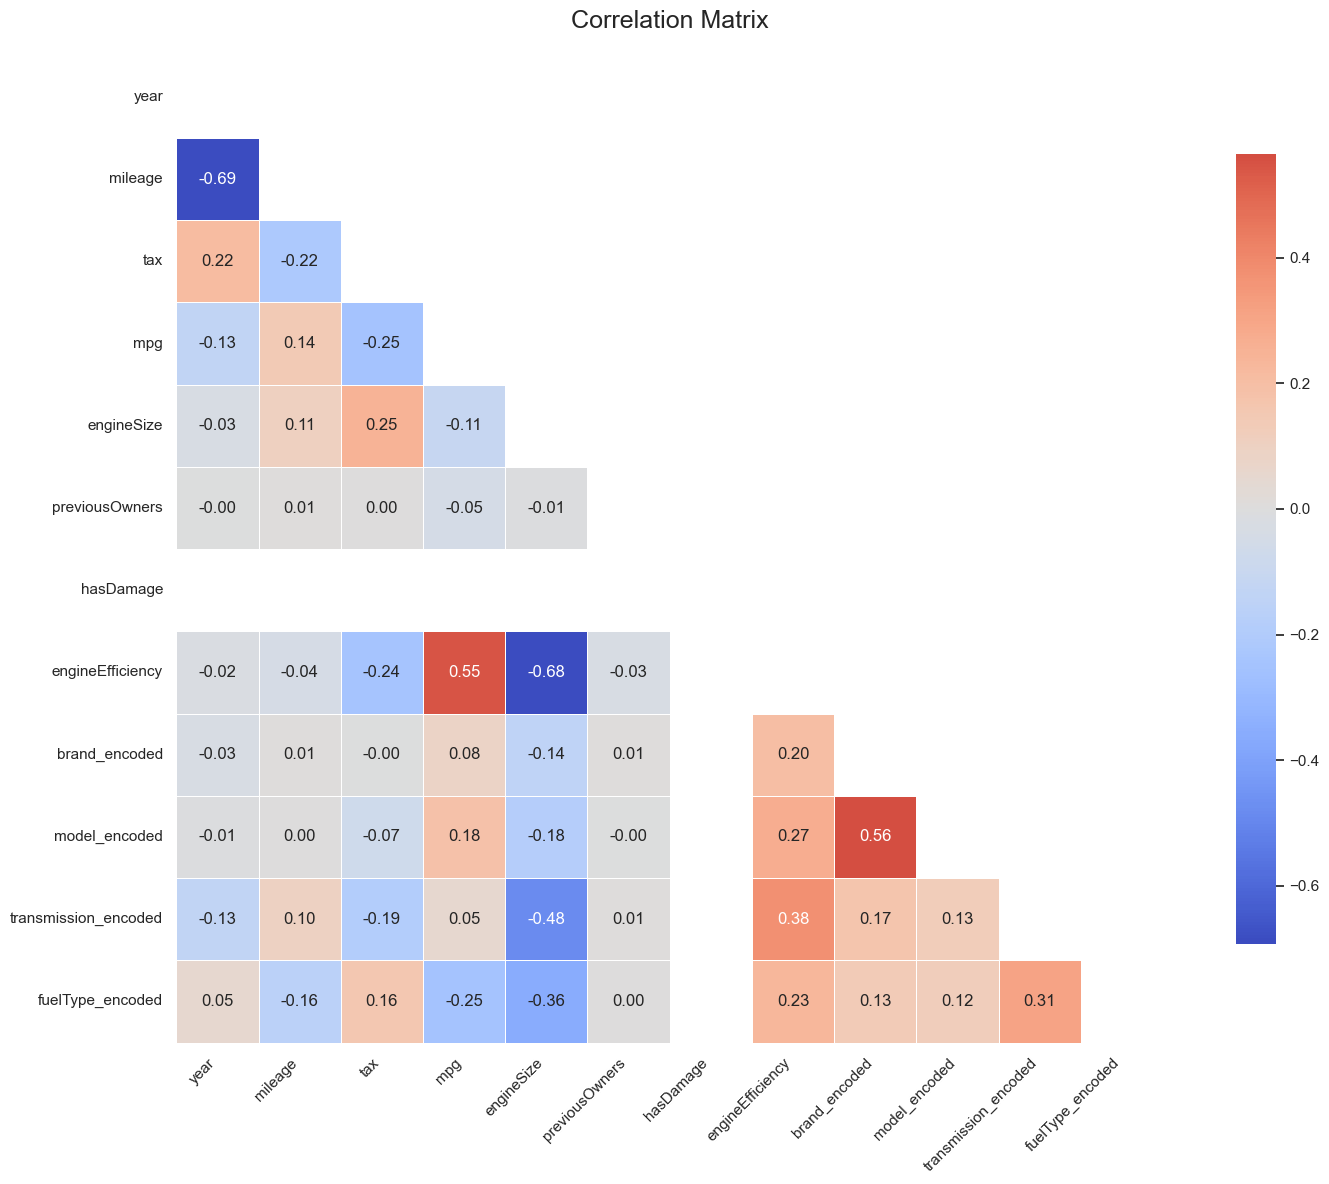

In [865]:
mask = np.triu(np.ones_like(cor_pearson, dtype=bool))

# Escolher um estilo de fundo branco
sns.set_theme(style="white")

# Criar a figura
plt.figure(figsize=(16, 12))

# Plotar o heatmap
sns.heatmap(
    cor_pearson,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

# Título e layout
plt.title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### 4.10.1.3. Mutual Information (MI)

In [867]:
print(X_train.shape, y_train.shape)

(52817, 12) (52817,)


In [868]:
mi_scores = mutual_info_regression(X_train, y_train, random_state=0)

mi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

print(mi_df.head(10))

top_mi_features = mi_df.head(15)['Feature']
X_train_mi = X_train[top_mi_features]

                 Feature  MI_Score
7       engineEfficiency  0.668173
9          model_encoded  0.594932
4             engineSize  0.377977
3                    mpg  0.371372
0                   year  0.333171
8          brand_encoded  0.308846
1                mileage  0.293969
10  transmission_encoded  0.231053
2                    tax  0.208786
11      fuelType_encoded  0.067237


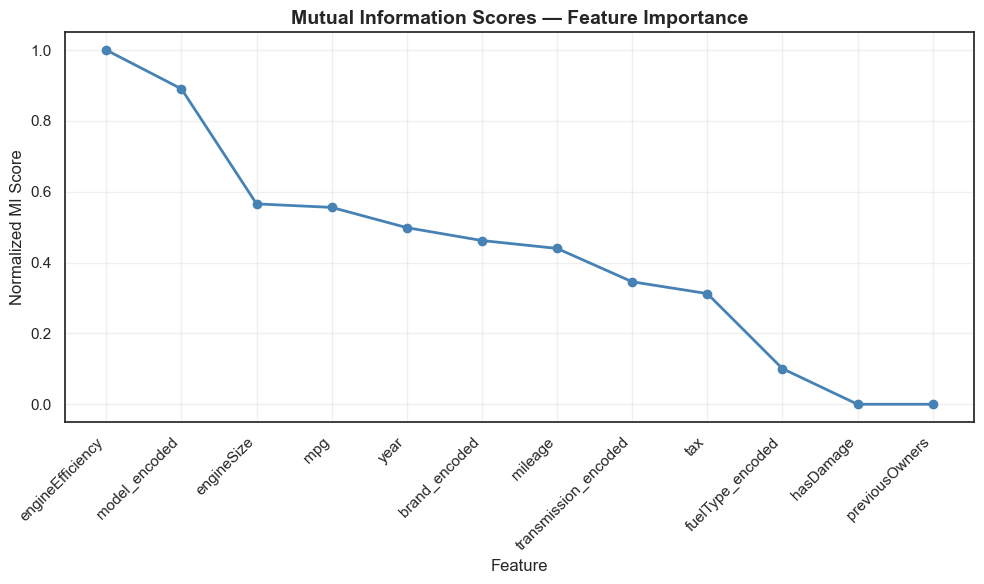

In [869]:
mi_df = mi_df.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)
mi_df['MI_Score_norm'] = mi_df['MI_Score'] / mi_df['MI_Score'].max()

# Plot clean MI curve
plt.figure(figsize=(10, 6))
plt.plot(mi_df['Feature'], mi_df['MI_Score_norm'], marker='o', color='steelblue', linewidth=2)
plt.title("Mutual Information Scores — Feature Importance", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Normalized MI Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tirar:
- fuelType_encoded
- hasDamage
- previousOwners
- tax
- transmission_encoded

#### 4.10.2. Wrapper Methods 

##### 4.10.2.1. RFE

In [ ]:
# Number of features to select

nof_list = np.arange(1, len(X_train.columns) + 1)
low_rmse = float('inf')  # NEW: Initialize comparison to infinity (high value)
# Variable to store the optimum features
nof = 0 
train_rmse_list = []      # NEW: Store RMSE instead of R-squared score
val_rmse_list = []        # NEW: Store RMSE instead of R-squared score

# --- RFE Loop using RMSE ---
for n in range(len(nof_list)):
    model = LinearRegression() # use LinearRegression as model
    
    # 1. Recursive Feature Elimination
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)
    
    # 2. Train Model on Subset
    model.fit(X_train_rfe, y_train)
    
    # 3. Calculate and Store Training RMSE
    y_train_pred = model.predict(X_train_rfe)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # 4. Calculate and Store Validation RMSE
    y_val_pred = model.predict(X_val_rfe)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_rmse_list.append(val_rmse)
    
    # 5. Check best score (finding the minimum RMSE)
    if(val_rmse <= low_rmse): # CHANGED: Look for the lowest RMSE (less than or equal)
        low_rmse = val_rmse
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Lowest RMSE with %d features: %f" % (nof, low_rmse))

In [ ]:
# Create plot to see RFE performance

x = np.arange(1, len(X_train.columns) + 1)

plt.figure(figsize=(10,6))
plt.plot(x, train_rmse_list, label='Training Score', color='yellowgreen', marker='o')
plt.plot(x, val_rmse_list, label='Validation Score', color='dimgray', marker='o')
plt.plot(nof, low_rmse, 'ro',label=f'Optimal Features: {nof} (RMSE: {low_rmse:.4f})', markersize=8)
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel("RMSE Score", fontsize=12)
plt.title("RFE Performance - Training vs Validation Scores", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Select features

final_model = LinearRegression()   # Use LinearRegression as model because we want to predict price which is a continuous variable
rfe_final = RFE(estimator=final_model, n_features_to_select=nof)
rfe_final.fit(X_train, y_train)    # Apply RFE to determine the best features in our dataset

# Get the mask of selected features
selected_features_11 = X_train.columns[rfe_final.support_]   # Obtain the best features

print("Selected features using RFE ({} features):".format(nof))
print(list(selected_features_11))

##### 4.10.2.2. RFECV

In [ ]:
# Combine train and validation datasets
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Create a test fold index (-1 for train, 0 for validation)
test_fold = [-1] * len(X_train) + [0] * len(X_val)

print('Test fold: ', len(test_fold))
print('X_combined: ', len(X_combined))
print('y_combined: ', len(y_combined))

# Define the PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

In [ ]:
# preprune random forest

base_estimator = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=10,
    min_samples_leaf = 4,
    max_features="sqrt",
    random_state=0,
    n_jobs=-1
)

In [ ]:
# Find number of features
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 3. Execute RFECV to find the optimal feature count based on Validation RMSE
# Using the balanced estimator for the primary optimization process.
rfecv_selector = RFECV(
    estimator=base_estimator, 
    step=1,
    cv=ps, # Uses the PredefinedSplit (X_val) for scoring
    scoring=neg_mse_scorer
)
rfecv_selector.fit(X_combined, y_combined)

# --- Define the range of features evaluated by RFECV (for the X-axis) ---
feature_counts_range = rfecv_selector.cv_results_['n_features']

# 4. Calculate Training RMSE for the plot (MANUAL LOOP CORRECTED)
# We calculate the Training score for each feature subset size determined by the ranking.
train_rmse_list = []
feature_ranking = rfecv_selector.ranking_

for n in feature_counts_range:
    # Identify the features selected at this step (rank <= n)
    selected_features_mask = feature_ranking <= n
    
    # Subset X_train using the mask, assuming X_train is a Pandas DataFrame.
    X_train_subset = X_train.iloc[:, selected_features_mask]
    
    # Train on the SUBSET of features
    base_estimator.fit(X_train_subset, y_train)
    
    # Predict and calculate Training RMSE on the SUBSET of features
    train_pred = base_estimator.predict(X_train_subset)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse_list.append(np.sqrt(train_mse))


# 5. Prepare Plotting Data and Output
optimal_nof = rfecv_selector.n_features_
validation_scores_neg_mse = rfecv_selector.cv_results_['mean_test_score']
# Convert Validation Negative MSE scores to positive RMSE
validation_rmse = np.sqrt(-validation_scores_neg_mse) 
# The index of the optimal number of features is optimal_nof - 1
min_rmse = validation_rmse[optimal_nof - 1] 

# Variables for Plotting
nof_list = feature_counts_range
val_rmse_list = validation_rmse
nof = optimal_nof
low_rmse = min_rmse

print("\n--- RFECV Results (Using Random Forest) ---")
print(f"Optimal number of features found: {nof}")
print(f"Minimum Validation RMSE achieved: {low_rmse:.4f}")

In [ ]:
# Plot figure

plt.figure(figsize=(10, 6))

# Training RMSE (NEWLY ADDED)
plt.plot(nof_list, train_rmse_list,
         label="RMSE on Training Set", color='yellowgreen', linewidth=2) 
         
# Validation RMSE
plt.plot(nof_list, val_rmse_list, 
         label="RMSE on Validation Set", color='dimgray', linewidth=2) 

# Highlight the optimal point
plt.plot(nof, low_rmse, 'ro', 
         label=f'Optimal Features: {nof} (RMSE: {low_rmse:.4f})', markersize=8)

plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE (Root Mean Squared Error)") 
plt.title("RFECV Performance: Training vs. Validation Error")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Get the mask of selected features (True for selected, False otherwise)
# rfecv_selector.support_ stores the mask corresponding to the optimal_nof
selected_feature_mask = rfecv_selector.support_

forward_features = X_train.columns[selected_feature_mask]

print("Selected features using RFECV ({} features):".format(optimal_nof))
print(list(forward_features))

##### 4.10.2.1. Sequential Feature Selector

In [ ]:
 #forward selection

sfs_forward = SequentialFeatureSelector(
    estimator=base_estimator,
    n_features_to_select="auto",   # Let SFS find optimal count
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=ps,                          # small CV to reduce compute
    n_jobs=-1,
    tol=1e-3  
)

sfs_forward.fit(X_combined, y_combined)

# Selected feature mask and names
forward_mask = sfs_forward.get_support()
forward_features = X_train.columns[forward_mask]

print("Forward Selected Features:")
print(list(forward_features))

# Evaluate on validation set
base_estimator.fit(X_train[forward_features], y_train)
y_val_pred_forward = base_estimator.predict(X_val[forward_features])
val_rmse_forward = np.sqrt(mean_squared_error(y_val, y_val_pred_forward))

# Calculate Training RMSE 
y_train_pred_forward = base_estimator.predict(X_train[forward_features])
train_rmse_forward = np.sqrt(mean_squared_error(y_train, y_train_pred_forward))

print("Training RMSE (Forward SFS):", train_rmse_forward)
print("Validation RMSE (Forward SFS):", val_rmse_forward)

In [ ]:
# Backward Selection
sfs_backward = SequentialFeatureSelector(
    estimator=base_estimator,
    n_features_to_select="auto", # Let SFS find optimal count
    direction="backward",        # Key change for Backward Selection
    scoring="neg_mean_squared_error",
    cv=ps,                       # Use the same PredefinedSplit
    n_jobs=-1,
    tol=1e-3
)

sfs_backward.fit(X_combined, y_combined)

# Selected feature mask and names
backward_mask = sfs_backward.get_support()
backward_features = X_train.columns[backward_mask] 

print("\nBackward Selected Features:")
print(list(backward_features))

# Evaluate on validation set
# We must use a fresh fit of the base_estimator on the optimally selected features
base_estimator.fit(X_train[backward_features], y_train)
y_val_pred_backward = base_estimator.predict(X_val[backward_features])
val_rmse_backward = np.sqrt(mean_squared_error(y_val, y_val_pred_backward))

# Calculate Training RMSE 
y_train_pred_backward = base_estimator.predict(X_train[backward_features])
train_rmse_backward = np.sqrt(mean_squared_error(y_train, y_train_pred_backward))

print("Training RMSE (Backward SFS):", train_rmse_backward)
print("Validation RMSE (Backward SFS):", val_rmse_backward)


Difference of around 200£, which is less than 7% of Training RMSE, so the model does not overfit.

### Final Insights

| Predictor            | Variance | Mutual Information | RFE (Linear regression) | RFECV (Random Forest) | SFS Forward | SFS Backward | Decision              |
|----------------------|----------|---------------------|----------|------------------------|-------------|--------------|------------------------|
| year                 | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| mileage              | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| tax                  | Keep     | Discard             | Keep     | Keep                   | Discard     | Discard      | Try with and without   |
| mpg                  | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| engineSize           | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| engineEfficiency     | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| brand_encoded        | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| model_encoded        | Keep     | Keep                | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| transmission_encoded | Keep     | Discard             | Keep     | Keep                   | Keep        | Keep         | Include in the model   |
| fuelType_encoded     | Keep     | Discard             | Discard  | Discard                | Discard     | Discard      | Discard                |
| previousOwners       | Keep     | Discard             | Discard  | Discard                | Discard     | Discard      | Discard                |
| hasDamage            | Discard  | Discard             | Discard  | Discard                | Discard     | Discard      | Discard                |
